In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.5


# Gaussian process models for stellar variability

When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

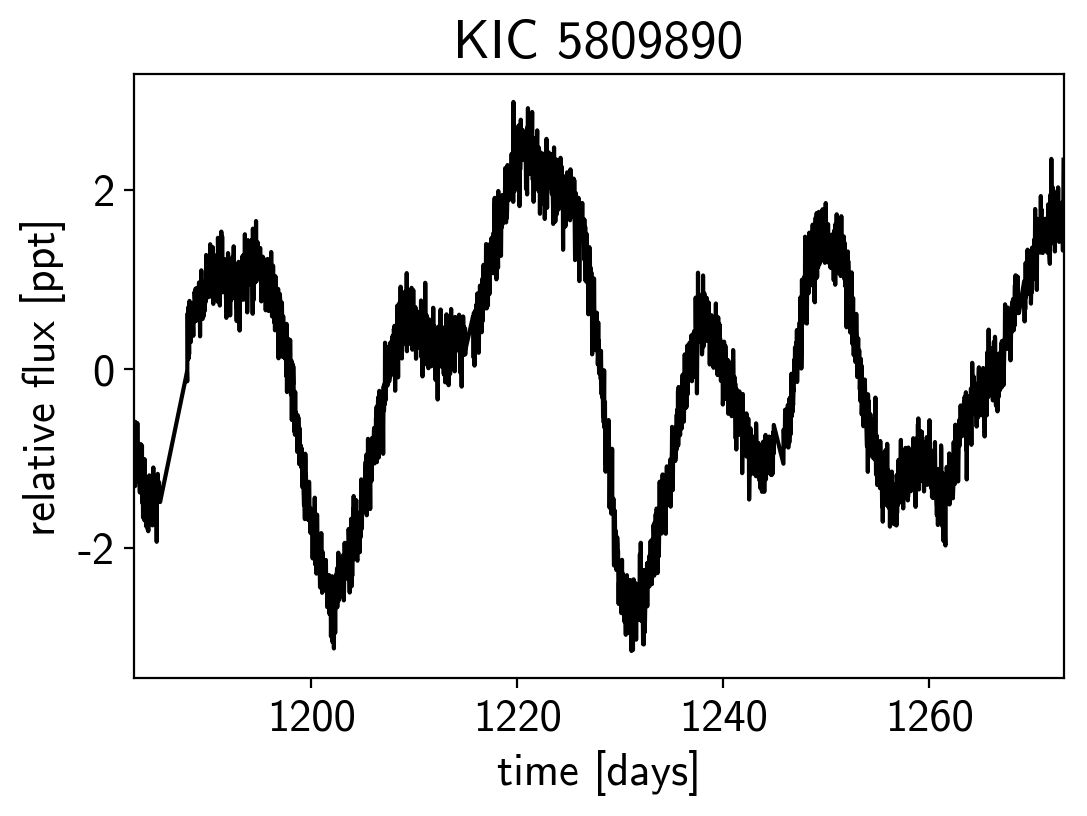

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

url = "https://archive.stsci.edu/missions/kepler/lightcurves/0058/005809890/kplr005809890-2012179063303_llc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    
x = data["TIME"]
y = data["PDCSAP_FLUX"]
yerr = data["PDCSAP_FLUX_ERR"]
m = (data["SAP_QUALITY"] == 0) & np.isfinite(x) & np.isfinite(y)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

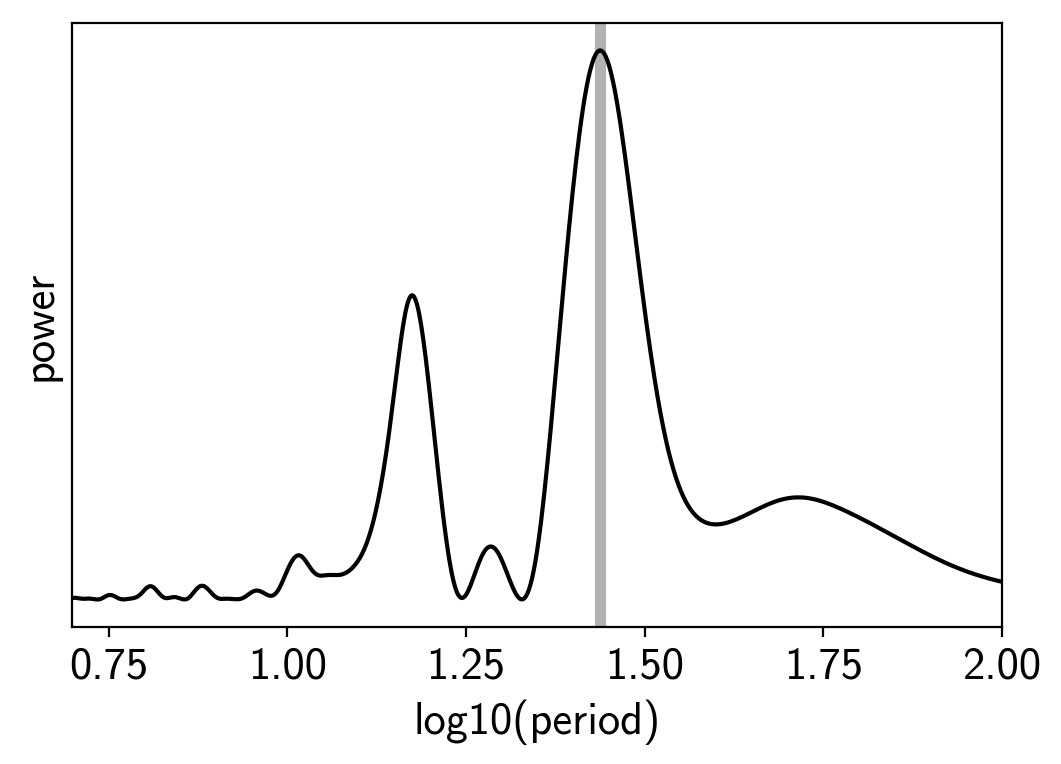

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    
    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)
    
    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))
    
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)
    
    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logs2', 'mean']


message: Optimization terminated successfully.
logp: 515.8061433750984 -> 692.7159093512395


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

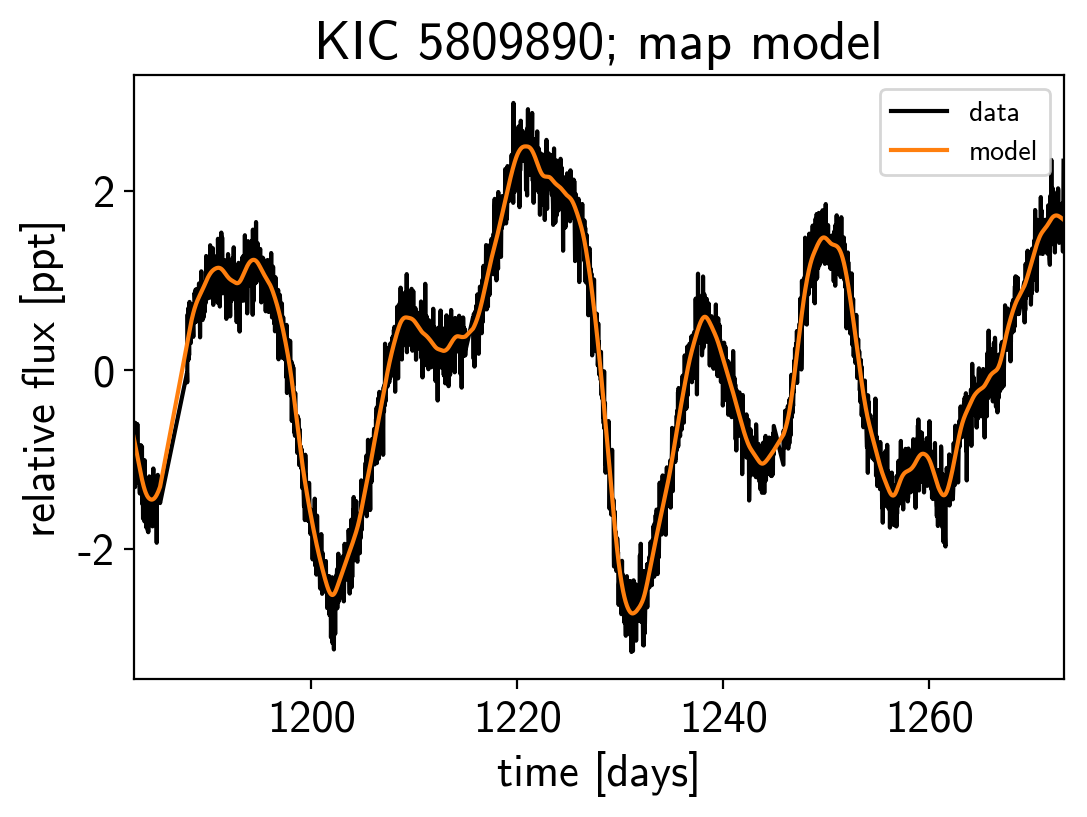

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using a :class:`exoplanet.PyMC3Sampler`.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▎         | 11/308 [00:00<00:03, 84.80draws/s]

Sampling 4 chains:   5%|▍         | 14/308 [00:00<00:08, 33.08draws/s]

Sampling 4 chains:   6%|▌         | 17/308 [00:00<00:21, 13.23draws/s]

Sampling 4 chains:   6%|▌         | 19/308 [00:01<00:20, 13.90draws/s]

Sampling 4 chains:   7%|▋         | 22/308 [00:01<00:20, 13.83draws/s]

Sampling 4 chains:   8%|▊         | 24/308 [00:01<00:32,  8.70draws/s]

Sampling 4 chains:   8%|▊         | 26/308 [00:01<00:29,  9.62draws/s]

Sampling 4 chains:   9%|▉         | 28/308 [00:01<00:27, 10.33draws/s]

Sampling 4 chains:  10%|▉         | 30/308 [00:02<00:26, 10.67draws/s]

Sampling 4 chains:  11%|█         | 34/308 [00:02<00:20, 13.37draws/s]

Sampling 4 chains:  12%|█▏        | 36/308 [00:02<00:18, 14.58draws/s]

Sampling 4 chains:  13%|█▎        | 40/308 [00:02<00:16, 16.54draws/s]

Sampling 4 chains:  14%|█▍        | 43/308 [00:02<00:15, 17.03draws/s]

Sampling 4 chains:  15%|█▍        | 46/308 [00:02<00:13, 18.74draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:03<00:15, 17.02draws/s]

Sampling 4 chains:  17%|█▋        | 52/308 [00:03<00:18, 13.84draws/s]

Sampling 4 chains:  18%|█▊        | 54/308 [00:03<00:17, 14.18draws/s]

Sampling 4 chains:  18%|█▊        | 56/308 [00:03<00:20, 12.17draws/s]

Sampling 4 chains:  19%|█▉        | 59/308 [00:03<00:20, 12.43draws/s]

Sampling 4 chains:  20%|█▉        | 61/308 [00:04<00:19, 12.41draws/s]

Sampling 4 chains:  20%|██        | 63/308 [00:04<00:25,  9.57draws/s]

Sampling 4 chains:  21%|██        | 65/308 [00:04<00:24, 10.04draws/s]

Sampling 4 chains:  22%|██▏       | 68/308 [00:04<00:19, 12.29draws/s]

Sampling 4 chains:  23%|██▎       | 71/308 [00:04<00:15, 14.93draws/s]

Sampling 4 chains:  24%|██▎       | 73/308 [00:05<00:20, 11.72draws/s]

Sampling 4 chains:  24%|██▍       | 75/308 [00:05<00:25,  9.11draws/s]

Sampling 4 chains:  25%|██▌       | 78/308 [00:05<00:20, 11.23draws/s]

Sampling 4 chains:  26%|██▌       | 80/308 [00:05<00:23,  9.68draws/s]

Sampling 4 chains:  27%|██▋       | 82/308 [00:05<00:21, 10.29draws/s]

Sampling 4 chains:  27%|██▋       | 84/308 [00:06<00:21, 10.56draws/s]

Sampling 4 chains:  29%|██▊       | 88/308 [00:06<00:16, 13.52draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:06<00:19, 11.10draws/s]

Sampling 4 chains:  30%|███       | 93/308 [00:06<00:16, 12.69draws/s]

Sampling 4 chains:  31%|███       | 96/308 [00:06<00:14, 14.71draws/s]

Sampling 4 chains:  32%|███▏      | 98/308 [00:07<00:21,  9.59draws/s]

Sampling 4 chains:  33%|███▎      | 101/308 [00:07<00:18, 11.39draws/s]

Sampling 4 chains:  34%|███▍      | 105/308 [00:07<00:14, 13.96draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:07<00:15, 13.22draws/s]

Sampling 4 chains:  36%|███▌      | 110/308 [00:07<00:14, 13.49draws/s]

Sampling 4 chains:  36%|███▋      | 112/308 [00:08<00:15, 12.84draws/s]

Sampling 4 chains:  37%|███▋      | 115/308 [00:08<00:12, 15.27draws/s]

Sampling 4 chains:  38%|███▊      | 117/308 [00:08<00:14, 12.79draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:08<00:16, 11.47draws/s]

Sampling 4 chains:  40%|███▉      | 122/308 [00:09<00:19,  9.58draws/s]

Sampling 4 chains:  40%|████      | 124/308 [00:09<00:22,  8.14draws/s]

Sampling 4 chains:  42%|████▏     | 128/308 [00:09<00:16, 10.70draws/s]

Sampling 4 chains:  42%|████▏     | 130/308 [00:10<00:26,  6.68draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:10<00:21,  8.21draws/s]

Sampling 4 chains:  44%|████▍     | 135/308 [00:10<00:18,  9.29draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:10<00:21,  7.79draws/s]

Sampling 4 chains:  45%|████▌     | 139/308 [00:10<00:18,  9.18draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [00:10<00:15, 10.94draws/s]

Sampling 4 chains:  46%|████▋     | 143/308 [00:11<00:23,  7.15draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [00:11<00:19,  8.33draws/s]

Sampling 4 chains:  48%|████▊     | 147/308 [00:11<00:16,  9.63draws/s]

Sampling 4 chains:  49%|████▊     | 150/308 [00:11<00:14, 11.20draws/s]

Sampling 4 chains:  49%|████▉     | 152/308 [00:12<00:16,  9.43draws/s]

Sampling 4 chains:  50%|█████     | 154/308 [00:12<00:14, 10.90draws/s]

Sampling 4 chains:  51%|█████     | 156/308 [00:12<00:12, 12.11draws/s]

Sampling 4 chains:  51%|█████▏    | 158/308 [00:12<00:10, 13.73draws/s]

Sampling 4 chains:  52%|█████▏    | 160/308 [00:12<00:11, 12.95draws/s]

Sampling 4 chains:  53%|█████▎    | 164/308 [00:12<00:09, 15.65draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [00:12<00:09, 14.33draws/s]

Sampling 4 chains:  55%|█████▍    | 168/308 [00:13<00:09, 15.07draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [00:13<00:08, 17.02draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:13<00:09, 13.80draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [00:13<00:10, 12.37draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [00:13<00:12, 10.71draws/s]

Sampling 4 chains:  58%|█████▊    | 179/308 [00:14<00:11, 11.11draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [00:14<00:12,  9.87draws/s]

Sampling 4 chains:  59%|█████▉    | 183/308 [00:14<00:11, 10.88draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [00:14<00:09, 12.51draws/s]

Sampling 4 chains:  61%|██████    | 188/308 [00:14<00:08, 14.09draws/s]

Sampling 4 chains:  62%|██████▏   | 190/308 [00:15<00:12,  9.28draws/s]

Sampling 4 chains:  62%|██████▏   | 192/308 [00:15<00:12,  9.53draws/s]

Sampling 4 chains:  63%|██████▎   | 194/308 [00:15<00:13,  8.21draws/s]

Sampling 4 chains:  64%|██████▍   | 197/308 [00:15<00:12,  9.22draws/s]

Sampling 4 chains:  65%|██████▍   | 199/308 [00:15<00:10, 10.43draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:16<00:09, 10.90draws/s]

Sampling 4 chains:  66%|██████▌   | 203/308 [00:16<00:09, 11.13draws/s]

Sampling 4 chains:  67%|██████▋   | 205/308 [00:16<00:12,  7.99draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [00:16<00:12,  8.22draws/s]

Sampling 4 chains:  68%|██████▊   | 209/308 [00:17<00:10,  9.81draws/s]

Sampling 4 chains:  69%|██████▉   | 212/308 [00:17<00:07, 12.15draws/s]

Sampling 4 chains:  70%|██████▉   | 215/308 [00:17<00:06, 14.77draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [00:17<00:05, 16.69draws/s]

Sampling 4 chains:  72%|███████▏  | 221/308 [00:17<00:05, 15.72draws/s]

Sampling 4 chains:  72%|███████▏  | 223/308 [00:17<00:05, 14.57draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [00:17<00:05, 14.68draws/s]

Sampling 4 chains:  74%|███████▍  | 229/308 [00:18<00:05, 14.51draws/s]

Sampling 4 chains:  75%|███████▌  | 231/308 [00:18<00:07,  9.95draws/s]

Sampling 4 chains:  76%|███████▌  | 233/308 [00:18<00:07, 10.07draws/s]

Sampling 4 chains:  76%|███████▋  | 235/308 [00:18<00:07,  9.93draws/s]

Sampling 4 chains:  77%|███████▋  | 237/308 [00:19<00:07,  9.93draws/s]

Sampling 4 chains:  78%|███████▊  | 240/308 [00:19<00:06, 10.22draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:19<00:05, 11.68draws/s]

Sampling 4 chains:  79%|███████▉  | 244/308 [00:19<00:05, 10.77draws/s]

Sampling 4 chains:  80%|████████  | 247/308 [00:20<00:05, 10.53draws/s]

Sampling 4 chains:  81%|████████  | 249/308 [00:20<00:04, 11.83draws/s]

Sampling 4 chains:  82%|████████▏ | 252/308 [00:20<00:03, 14.03draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:20<00:04, 13.29draws/s]

Sampling 4 chains:  83%|████████▎ | 256/308 [00:20<00:03, 14.54draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:20<00:05,  9.72draws/s]

Sampling 4 chains:  84%|████████▍ | 260/308 [00:21<00:05,  9.45draws/s]

Sampling 4 chains:  86%|████████▌ | 264/308 [00:21<00:03, 12.11draws/s]

Sampling 4 chains:  87%|████████▋ | 269/308 [00:21<00:02, 15.07draws/s]

Sampling 4 chains:  88%|████████▊ | 272/308 [00:21<00:02, 17.09draws/s]

Sampling 4 chains:  89%|████████▉ | 275/308 [00:21<00:01, 17.53draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:21<00:01, 15.77draws/s]

Sampling 4 chains:  91%|█████████ | 280/308 [00:22<00:01, 15.79draws/s]

Sampling 4 chains:  92%|█████████▏| 283/308 [00:22<00:01, 18.14draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:22<00:01, 15.96draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [00:22<00:01, 10.58draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:23<00:02,  8.67draws/s]

Sampling 4 chains:  95%|█████████▍| 292/308 [00:23<00:02,  7.64draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:23<00:01,  7.91draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [00:23<00:01,  8.00draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:24<00:01,  9.36draws/s]

Sampling 4 chains:  97%|█████████▋| 300/308 [00:24<00:00,  9.00draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:24<00:00,  6.78draws/s]

Sampling 4 chains:  98%|█████████▊| 303/308 [00:24<00:00,  6.13draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [00:25<00:00,  6.25draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:25<00:00,  5.69draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:25<00:00,  5.82draws/s]

Sampling 4 chains: 100%|█████████▉| 307/308 [00:26<00:00,  3.18draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:26<00:00,  3.07draws/s]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:   9%|▉         | 10/108 [00:00<00:01, 88.07draws/s]

Sampling 4 chains:  12%|█▏        | 13/108 [00:00<00:01, 53.47draws/s]

Sampling 4 chains:  16%|█▌        | 17/108 [00:00<00:01, 48.44draws/s]

Sampling 4 chains:  19%|█▉        | 21/108 [00:00<00:02, 31.91draws/s]

Sampling 4 chains:  22%|██▏       | 24/108 [00:00<00:03, 26.01draws/s]

Sampling 4 chains:  25%|██▌       | 27/108 [00:00<00:03, 23.94draws/s]

Sampling 4 chains:  29%|██▊       | 31/108 [00:01<00:03, 24.34draws/s]

Sampling 4 chains:  31%|███▏      | 34/108 [00:01<00:04, 16.37draws/s]

Sampling 4 chains:  33%|███▎      | 36/108 [00:01<00:04, 14.61draws/s]

Sampling 4 chains:  36%|███▌      | 39/108 [00:01<00:04, 16.79draws/s]

Sampling 4 chains:  38%|███▊      | 41/108 [00:01<00:04, 13.69draws/s]

Sampling 4 chains:  41%|████      | 44/108 [00:01<00:04, 15.89draws/s]

Sampling 4 chains:  44%|████▍     | 48/108 [00:02<00:03, 17.62draws/s]

Sampling 4 chains:  48%|████▊     | 52/108 [00:02<00:02, 20.48draws/s]

Sampling 4 chains:  51%|█████     | 55/108 [00:02<00:02, 19.70draws/s]

Sampling 4 chains:  54%|█████▎    | 58/108 [00:02<00:03, 12.77draws/s]

Sampling 4 chains:  59%|█████▉    | 64/108 [00:02<00:02, 16.16draws/s]

Sampling 4 chains:  62%|██████▏   | 67/108 [00:03<00:02, 13.98draws/s]

Sampling 4 chains:  65%|██████▍   | 70/108 [00:03<00:03, 11.25draws/s]

Sampling 4 chains:  68%|██████▊   | 73/108 [00:03<00:02, 13.41draws/s]

Sampling 4 chains:  70%|███████   | 76/108 [00:03<00:02, 15.05draws/s]

Sampling 4 chains:  73%|███████▎  | 79/108 [00:04<00:01, 15.69draws/s]

Sampling 4 chains:  76%|███████▌  | 82/108 [00:04<00:01, 16.59draws/s]

Sampling 4 chains:  78%|███████▊  | 84/108 [00:04<00:01, 13.62draws/s]

Sampling 4 chains:  81%|████████  | 87/108 [00:04<00:01, 13.24draws/s]

Sampling 4 chains:  82%|████████▏ | 89/108 [00:04<00:01, 12.48draws/s]

Sampling 4 chains:  84%|████████▍ | 91/108 [00:05<00:01, 11.16draws/s]

Sampling 4 chains:  88%|████████▊ | 95/108 [00:05<00:00, 13.94draws/s]

Sampling 4 chains:  90%|████████▉ | 97/108 [00:05<00:00, 15.20draws/s]

Sampling 4 chains:  92%|█████████▏| 99/108 [00:05<00:00, 13.99draws/s]

Sampling 4 chains:  94%|█████████▍| 102/108 [00:05<00:00, 15.18draws/s]

Sampling 4 chains:  96%|█████████▋| 104/108 [00:05<00:00, 15.88draws/s]

Sampling 4 chains:  98%|█████████▊| 106/108 [00:05<00:00, 13.51draws/s]

Sampling 4 chains: 100%|██████████| 108/108 [00:06<00:00, 17.79draws/s]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 7/208 [00:00<00:02, 67.52draws/s]

Sampling 4 chains:   7%|▋         | 15/208 [00:00<00:02, 68.41draws/s]

Sampling 4 chains:  11%|█         | 22/208 [00:00<00:02, 64.52draws/s]

Sampling 4 chains:  14%|█▍        | 30/208 [00:00<00:02, 67.60draws/s]

Sampling 4 chains:  18%|█▊        | 38/208 [00:00<00:02, 69.09draws/s]

Sampling 4 chains:  23%|██▎       | 47/208 [00:00<00:02, 73.75draws/s]

Sampling 4 chains:  27%|██▋       | 56/208 [00:00<00:01, 77.40draws/s]

Sampling 4 chains:  31%|███       | 64/208 [00:00<00:01, 72.21draws/s]

Sampling 4 chains:  34%|███▍      | 71/208 [00:01<00:01, 69.12draws/s]

Sampling 4 chains:  38%|███▊      | 80/208 [00:01<00:01, 71.46draws/s]

Sampling 4 chains:  43%|████▎     | 89/208 [00:01<00:01, 76.09draws/s]

Sampling 4 chains:  47%|████▋     | 97/208 [00:01<00:01, 71.59draws/s]

Sampling 4 chains:  51%|█████     | 106/208 [00:01<00:01, 72.75draws/s]

Sampling 4 chains:  55%|█████▍    | 114/208 [00:01<00:01, 74.46draws/s]

Sampling 4 chains:  59%|█████▊    | 122/208 [00:01<00:01, 65.61draws/s]

Sampling 4 chains:  62%|██████▏   | 129/208 [00:01<00:01, 57.45draws/s]

Sampling 4 chains:  65%|██████▌   | 136/208 [00:02<00:01, 51.47draws/s]

Sampling 4 chains:  69%|██████▉   | 143/208 [00:02<00:01, 55.78draws/s]

Sampling 4 chains:  72%|███████▏  | 150/208 [00:02<00:00, 58.68draws/s]

Sampling 4 chains:  77%|███████▋  | 160/208 [00:02<00:00, 66.35draws/s]

Sampling 4 chains:  81%|████████▏ | 169/208 [00:02<00:00, 67.93draws/s]

Sampling 4 chains:  86%|████████▌ | 178/208 [00:02<00:00, 67.93draws/s]

Sampling 4 chains:  89%|████████▉ | 186/208 [00:02<00:00, 65.99draws/s]

Sampling 4 chains:  93%|█████████▎| 194/208 [00:02<00:00, 64.52draws/s]

Sampling 4 chains:  97%|█████████▋| 201/208 [00:03<00:00, 50.36draws/s]

Sampling 4 chains: 100%|█████████▉| 207/208 [00:03<00:00, 41.22draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [00:03<00:00, 61.30draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 10/408 [00:00<00:04, 85.99draws/s]

Sampling 4 chains:   4%|▍         | 16/408 [00:00<00:05, 70.20draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:05, 74.57draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:04, 75.29draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:00<00:04, 82.49draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:00<00:04, 82.41draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:00<00:04, 81.26draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:00<00:04, 75.22draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:01<00:04, 69.36draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:01<00:04, 65.28draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:01<00:05, 62.76draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:01<00:04, 63.55draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:01<00:05, 56.35draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:01<00:05, 56.65draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:01<00:05, 56.68draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:01<00:05, 54.61draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:02<00:05, 53.04draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:02<00:05, 53.40draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:02<00:05, 47.18draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:02<00:05, 48.09draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:02<00:04, 50.93draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:02<00:04, 53.06draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:02<00:04, 50.97draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:02<00:04, 53.25draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:02<00:03, 59.26draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:03<00:03, 59.56draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:03<00:03, 62.23draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:03<00:03, 64.02draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:03<00:03, 57.92draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:03<00:03, 60.90draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:03<00:03, 58.23draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:03<00:02, 59.55draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:03<00:02, 64.71draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:04<00:02, 61.98draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:04<00:02, 65.79draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:04<00:02, 66.12draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:04<00:01, 68.57draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:04<00:01, 68.04draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:04<00:01, 68.03draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:04<00:01, 70.79draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:04<00:01, 78.71draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:04<00:01, 80.39draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:05<00:01, 74.26draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:05<00:00, 77.04draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:05<00:00, 71.10draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:05<00:00, 64.36draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:05<00:00, 62.67draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:05<00:00, 59.93draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:05<00:00, 51.73draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:05<00:00, 53.49draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [00:06<00:00, 57.21draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:06<00:00, 57.14draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:06<00:00, 52.10draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:06<00:00, 53.17draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:06<00:00, 61.59draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 8/808 [00:00<00:10, 76.46draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:10, 72.84draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:00<00:11, 70.33draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:10, 76.93draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:00<00:10, 73.68draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:00<00:11, 68.49draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:00<00:11, 65.03draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:00<00:10, 72.40draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:00<00:10, 69.11draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:01<00:09, 73.36draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:01<00:09, 75.08draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:01<00:08, 80.75draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:01<00:08, 78.47draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:01<00:09, 69.80draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:01<00:10, 67.63draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:01<00:09, 74.09draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:01<00:10, 65.23draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:02<00:11, 57.30draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:02<00:10, 60.46draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:02<00:09, 64.61draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:02<00:10, 59.33draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:02<00:10, 57.46draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:02<00:11, 55.62draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:02<00:10, 60.04draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:02<00:09, 61.83draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:03<00:09, 62.94draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:03<00:08, 65.86draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:03<00:08, 70.20draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:03<00:07, 72.75draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:03<00:07, 73.68draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:03<00:07, 75.58draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:03<00:07, 75.37draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:03<00:07, 73.24draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:03<00:06, 78.49draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:04<00:06, 78.44draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:04<00:05, 88.72draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:04<00:05, 93.46draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:04<00:04, 97.36draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:04<00:04, 96.10draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:04<00:05, 87.80draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:04<00:05, 77.35draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:04<00:05, 80.84draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:05<00:05, 79.01draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:05<00:05, 79.54draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:05<00:05, 71.92draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:05<00:05, 68.34draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:05<00:05, 72.53draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:05<00:04, 80.78draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [00:05<00:04, 81.99draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [00:05<00:04, 80.24draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:06<00:04, 75.61draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:06<00:04, 81.05draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:06<00:04, 83.31draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:06<00:03, 86.53draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:06<00:04, 76.79draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:06<00:04, 71.80draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:06<00:04, 69.22draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:06<00:04, 71.82draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [00:06<00:03, 77.97draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:07<00:03, 79.39draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:07<00:03, 84.36draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:07<00:03, 85.15draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:07<00:02, 86.22draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [00:07<00:03, 73.73draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:07<00:03, 64.17draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:07<00:03, 64.76draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:07<00:03, 66.66draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:08<00:03, 68.44draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:08<00:02, 75.11draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:08<00:02, 77.91draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:08<00:02, 80.14draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:08<00:02, 71.62draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:08<00:02, 71.49draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:08<00:01, 79.44draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:08<00:01, 86.12draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:09<00:01, 76.66draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:09<00:01, 82.50draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:09<00:01, 81.29draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:09<00:01, 77.34draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:09<00:01, 80.30draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:09<00:01, 81.60draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:09<00:00, 77.83draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:09<00:00, 69.79draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:09<00:00, 65.42draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:10<00:00, 66.25draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:10<00:00, 66.50draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:10<00:00, 63.12draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:10<00:00, 59.57draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:10<00:00, 52.86draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:10<00:00, 56.62draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:10<00:00, 51.95draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:11<00:00, 43.45draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:11<00:00, 72.43draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:20, 78.29draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:00<00:22, 71.09draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<00:23, 66.66draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:00<00:23, 66.32draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:00<00:23, 66.64draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:00<00:23, 67.21draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:00<00:24, 64.31draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:00<00:24, 62.47draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:00<00:28, 54.15draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:01<00:27, 56.94draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:01<00:27, 55.48draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:01<00:27, 56.47draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:01<00:27, 55.61draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:01<00:26, 58.10draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:01<00:23, 63.25draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:01<00:23, 64.73draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:01<00:23, 64.63draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:02<00:27, 53.51draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:02<00:26, 55.56draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:02<00:24, 60.54draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:02<00:25, 56.46draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:02<00:28, 51.03draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:02<00:26, 54.14draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:02<00:27, 53.11draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:02<00:26, 53.66draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:03<00:26, 53.62draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:03<00:24, 58.82draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:03<00:22, 62.90draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:03<00:24, 57.08draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:03<00:23, 59.98draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [00:03<00:30, 45.70draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:03<00:31, 44.44draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:03<00:31, 44.53draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:04<00:28, 48.28draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [00:04<00:26, 52.43draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [00:04<00:23, 57.26draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:04<00:23, 57.76draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:04<00:23, 56.98draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:04<00:27, 49.40draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:04<00:27, 48.40draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:04<00:27, 49.13draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:05<00:23, 56.11draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:05<00:21, 61.57draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:05<00:18, 70.34draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:05<00:20, 62.11draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [00:05<00:21, 60.43draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [00:05<00:21, 58.15draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [00:05<00:23, 54.71draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:06<00:25, 49.76draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [00:06<00:22, 54.76draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [00:06<00:20, 59.36draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [00:06<00:24, 50.73draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:06<00:24, 50.17draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:06<00:23, 52.64draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:06<00:21, 56.48draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:06<00:19, 62.04draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [00:07<00:18, 64.72draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:07<00:15, 74.46draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [00:07<00:15, 76.56draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:07<00:15, 76.10draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [00:07<00:13, 83.57draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:07<00:13, 85.62draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [00:07<00:13, 82.78draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [00:07<00:15, 72.01draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [00:08<00:17, 63.44draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [00:08<00:19, 58.37draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [00:08<00:17, 63.14draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [00:08<00:17, 63.10draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:08<00:15, 69.23draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [00:08<00:17, 63.39draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:08<00:16, 64.28draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [00:08<00:17, 60.87draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [00:08<00:16, 64.40draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:09<00:15, 69.97draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [00:09<00:14, 71.44draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [00:09<00:14, 71.75draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [00:09<00:12, 79.34draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [00:09<00:12, 84.13draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [00:09<00:12, 82.11draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [00:09<00:11, 87.43draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [00:09<00:10, 94.00draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [00:09<00:10, 95.50draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [00:10<00:09, 96.40draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [00:10<00:11, 83.54draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [00:10<00:11, 80.14draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [00:10<00:12, 76.32draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [00:10<00:13, 66.77draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [00:10<00:13, 68.58draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [00:10<00:13, 66.58draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [00:10<00:13, 65.50draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [00:11<00:14, 63.43draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [00:11<00:13, 65.72draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [00:11<00:13, 65.75draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [00:11<00:13, 65.18draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [00:11<00:12, 68.09draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [00:11<00:12, 70.46draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [00:11<00:11, 76.50draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [00:11<00:10, 81.72draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [00:11<00:10, 77.54draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [00:12<00:11, 68.24draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [00:12<00:12, 66.84draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [00:12<00:12, 62.90draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [00:12<00:11, 68.65draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [00:12<00:11, 69.81draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [00:12<00:11, 68.37draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [00:12<00:10, 71.59draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [00:12<00:10, 73.87draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [00:13<00:10, 72.90draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [00:13<00:09, 76.31draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [00:13<00:09, 79.19draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [00:13<00:08, 81.14draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [00:13<00:08, 82.22draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [00:13<00:08, 79.02draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [00:13<00:08, 78.21draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [00:13<00:09, 75.80draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [00:13<00:08, 81.69draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [00:14<00:09, 71.73draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [00:14<00:09, 73.12draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [00:14<00:08, 72.72draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [00:14<00:10, 61.78draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [00:14<00:10, 60.32draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [00:14<00:10, 61.83draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [00:14<00:09, 66.10draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [00:14<00:09, 61.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [00:15<00:09, 61.62draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [00:15<00:09, 64.16draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [00:15<00:08, 69.55draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [00:15<00:08, 65.90draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [00:15<00:08, 70.63draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [00:15<00:09, 59.64draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [00:15<00:09, 59.25draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [00:16<00:09, 59.04draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [00:16<00:08, 60.34draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [00:16<00:09, 56.02draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [00:16<00:09, 58.57draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [00:16<00:08, 62.49draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [00:16<00:07, 66.09draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [00:16<00:06, 71.32draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [00:16<00:06, 75.83draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [00:16<00:06, 72.04draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [00:17<00:06, 69.66draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [00:17<00:06, 68.45draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [00:17<00:06, 70.63draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [00:17<00:06, 69.04draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [00:17<00:06, 71.35draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [00:17<00:06, 68.94draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [00:17<00:06, 68.82draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [00:17<00:05, 71.39draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [00:18<00:05, 69.37draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [00:18<00:06, 65.60draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [00:18<00:05, 73.14draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [00:18<00:05, 73.21draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [00:18<00:05, 73.83draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [00:18<00:04, 73.44draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [00:18<00:05, 69.77draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [00:18<00:05, 68.33draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [00:18<00:04, 70.96draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [00:19<00:04, 69.13draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [00:19<00:04, 77.37draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [00:19<00:03, 81.27draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [00:19<00:03, 78.45draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [00:19<00:03, 83.74draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [00:19<00:03, 72.13draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [00:19<00:04, 63.26draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [00:19<00:03, 69.02draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [00:20<00:03, 71.67draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [00:20<00:03, 66.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [00:20<00:03, 66.89draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [00:20<00:03, 71.97draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [00:20<00:03, 64.63draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [00:20<00:03, 66.59draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [00:20<00:03, 63.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [00:20<00:03, 67.03draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [00:21<00:02, 65.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [00:21<00:03, 62.92draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [00:21<00:02, 61.17draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [00:21<00:02, 63.25draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [00:21<00:02, 62.66draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [00:21<00:02, 62.37draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [00:21<00:02, 66.53draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [00:21<00:02, 68.57draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [00:21<00:01, 72.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [00:22<00:01, 72.57draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [00:22<00:01, 67.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [00:22<00:01, 67.40draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [00:22<00:01, 71.52draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [00:22<00:01, 75.77draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [00:22<00:01, 73.30draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [00:22<00:00, 77.97draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [00:22<00:00, 77.68draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [00:22<00:00, 72.33draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [00:23<00:00, 67.55draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [00:23<00:00, 57.24draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [00:23<00:00, 56.59draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [00:23<00:00, 56.23draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [00:23<00:00, 58.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [00:23<00:00, 54.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [00:24<00:00, 40.04draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [00:24<00:00, 30.21draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [00:24<00:00, 28.00draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:24<00:00, 65.44draws/s]

Sampling 4 chains:   0%|          | 0/4608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 11/4608 [00:00<00:48, 94.08draws/s]

Sampling 4 chains:   0%|          | 18/4608 [00:00<00:54, 84.59draws/s]

Sampling 4 chains:   1%|          | 24/4608 [00:00<01:04, 71.62draws/s]

Sampling 4 chains:   1%|          | 29/4608 [00:00<01:18, 58.48draws/s]

Sampling 4 chains:   1%|          | 34/4608 [00:00<01:24, 54.00draws/s]

Sampling 4 chains:   1%|          | 41/4608 [00:00<01:21, 56.11draws/s]

Sampling 4 chains:   1%|          | 48/4608 [00:00<01:18, 58.36draws/s]

Sampling 4 chains:   1%|          | 55/4608 [00:00<01:14, 61.37draws/s]

Sampling 4 chains:   1%|▏         | 64/4608 [00:01<01:09, 65.01draws/s]

Sampling 4 chains:   2%|▏         | 74/4608 [00:01<01:03, 71.44draws/s]

Sampling 4 chains:   2%|▏         | 83/4608 [00:01<01:01, 73.81draws/s]

Sampling 4 chains:   2%|▏         | 91/4608 [00:01<01:07, 66.43draws/s]

Sampling 4 chains:   2%|▏         | 98/4608 [00:01<01:11, 62.66draws/s]

Sampling 4 chains:   2%|▏         | 105/4608 [00:01<01:20, 55.59draws/s]

Sampling 4 chains:   2%|▏         | 115/4608 [00:01<01:12, 62.35draws/s]

Sampling 4 chains:   3%|▎         | 122/4608 [00:01<01:17, 57.70draws/s]

Sampling 4 chains:   3%|▎         | 129/4608 [00:02<01:16, 58.49draws/s]

Sampling 4 chains:   3%|▎         | 138/4608 [00:02<01:12, 61.26draws/s]

Sampling 4 chains:   3%|▎         | 147/4608 [00:02<01:07, 65.66draws/s]

Sampling 4 chains:   3%|▎         | 155/4608 [00:02<01:04, 69.03draws/s]

Sampling 4 chains:   4%|▎         | 163/4608 [00:02<01:03, 69.91draws/s]

Sampling 4 chains:   4%|▎         | 172/4608 [00:02<01:03, 70.28draws/s]

Sampling 4 chains:   4%|▍         | 180/4608 [00:02<01:04, 68.69draws/s]

Sampling 4 chains:   4%|▍         | 187/4608 [00:02<01:04, 68.77draws/s]

Sampling 4 chains:   4%|▍         | 198/4608 [00:02<00:59, 74.23draws/s]

Sampling 4 chains:   4%|▍         | 206/4608 [00:03<01:01, 71.19draws/s]

Sampling 4 chains:   5%|▍         | 217/4608 [00:03<00:58, 75.14draws/s]

Sampling 4 chains:   5%|▍         | 227/4608 [00:03<00:56, 77.41draws/s]

Sampling 4 chains:   5%|▌         | 237/4608 [00:03<00:53, 82.00draws/s]

Sampling 4 chains:   5%|▌         | 246/4608 [00:03<00:52, 83.58draws/s]

Sampling 4 chains:   6%|▌         | 255/4608 [00:03<00:55, 77.98draws/s]

Sampling 4 chains:   6%|▌         | 263/4608 [00:03<01:09, 62.88draws/s]

Sampling 4 chains:   6%|▌         | 270/4608 [00:03<01:11, 60.89draws/s]

Sampling 4 chains:   6%|▌         | 277/4608 [00:04<01:08, 62.87draws/s]

Sampling 4 chains:   6%|▌         | 284/4608 [00:04<01:08, 63.27draws/s]

Sampling 4 chains:   6%|▋         | 294/4608 [00:04<01:00, 70.85draws/s]

Sampling 4 chains:   7%|▋         | 302/4608 [00:04<01:01, 69.86draws/s]

Sampling 4 chains:   7%|▋         | 311/4608 [00:04<00:58, 73.98draws/s]

Sampling 4 chains:   7%|▋         | 319/4608 [00:04<00:56, 75.56draws/s]

Sampling 4 chains:   7%|▋         | 327/4608 [00:04<00:58, 72.56draws/s]

Sampling 4 chains:   7%|▋         | 337/4608 [00:04<00:56, 75.75draws/s]

Sampling 4 chains:   7%|▋         | 345/4608 [00:04<00:55, 76.18draws/s]

Sampling 4 chains:   8%|▊         | 353/4608 [00:05<01:01, 69.72draws/s]

Sampling 4 chains:   8%|▊         | 362/4608 [00:05<00:58, 72.44draws/s]

Sampling 4 chains:   8%|▊         | 373/4608 [00:05<00:54, 78.32draws/s]

Sampling 4 chains:   8%|▊         | 383/4608 [00:05<00:53, 79.38draws/s]

Sampling 4 chains:   9%|▊         | 392/4608 [00:05<01:00, 70.00draws/s]

Sampling 4 chains:   9%|▊         | 400/4608 [00:05<00:59, 71.15draws/s]

Sampling 4 chains:   9%|▉         | 408/4608 [00:05<01:00, 69.23draws/s]

Sampling 4 chains:   9%|▉         | 416/4608 [00:05<01:00, 68.81draws/s]

Sampling 4 chains:   9%|▉         | 424/4608 [00:06<01:01, 68.58draws/s]

Sampling 4 chains:   9%|▉         | 431/4608 [00:06<01:07, 61.47draws/s]

Sampling 4 chains:  10%|▉         | 438/4608 [00:06<01:07, 61.88draws/s]

Sampling 4 chains:  10%|▉         | 445/4608 [00:06<01:08, 61.20draws/s]

Sampling 4 chains:  10%|▉         | 452/4608 [00:06<01:10, 58.98draws/s]

Sampling 4 chains:  10%|█         | 461/4608 [00:06<01:04, 63.94draws/s]

Sampling 4 chains:  10%|█         | 471/4608 [00:06<00:58, 70.66draws/s]

Sampling 4 chains:  10%|█         | 481/4608 [00:06<00:54, 75.74draws/s]

Sampling 4 chains:  11%|█         | 492/4608 [00:07<00:50, 81.17draws/s]

Sampling 4 chains:  11%|█         | 501/4608 [00:07<00:50, 80.87draws/s]

Sampling 4 chains:  11%|█         | 510/4608 [00:07<00:57, 71.67draws/s]

Sampling 4 chains:  11%|█         | 518/4608 [00:07<00:59, 69.31draws/s]

Sampling 4 chains:  11%|█▏        | 528/4608 [00:07<00:54, 75.18draws/s]

Sampling 4 chains:  12%|█▏        | 538/4608 [00:07<00:51, 79.07draws/s]

Sampling 4 chains:  12%|█▏        | 547/4608 [00:07<00:52, 77.38draws/s]

Sampling 4 chains:  12%|█▏        | 555/4608 [00:07<00:52, 76.51draws/s]

Sampling 4 chains:  12%|█▏        | 563/4608 [00:07<00:56, 72.08draws/s]

Sampling 4 chains:  12%|█▏        | 571/4608 [00:08<00:58, 69.31draws/s]

Sampling 4 chains:  13%|█▎        | 579/4608 [00:08<00:57, 70.10draws/s]

Sampling 4 chains:  13%|█▎        | 589/4608 [00:08<00:52, 76.64draws/s]

Sampling 4 chains:  13%|█▎        | 597/4608 [00:08<00:52, 76.20draws/s]

Sampling 4 chains:  13%|█▎        | 605/4608 [00:08<00:54, 73.18draws/s]

Sampling 4 chains:  13%|█▎        | 613/4608 [00:08<00:53, 74.98draws/s]

Sampling 4 chains:  13%|█▎        | 622/4608 [00:08<00:52, 75.23draws/s]

Sampling 4 chains:  14%|█▎        | 632/4608 [00:08<00:49, 80.80draws/s]

Sampling 4 chains:  14%|█▍        | 641/4608 [00:09<00:53, 74.68draws/s]

Sampling 4 chains:  14%|█▍        | 649/4608 [00:09<00:53, 74.58draws/s]

Sampling 4 chains:  14%|█▍        | 658/4608 [00:09<00:50, 78.26draws/s]

Sampling 4 chains:  15%|█▍        | 671/4608 [00:09<00:44, 87.99draws/s]

Sampling 4 chains:  15%|█▍        | 681/4608 [00:09<00:45, 86.97draws/s]

Sampling 4 chains:  15%|█▍        | 691/4608 [00:09<00:46, 83.65draws/s]

Sampling 4 chains:  15%|█▌        | 700/4608 [00:09<00:49, 79.23draws/s]

Sampling 4 chains:  15%|█▌        | 709/4608 [00:09<00:50, 77.67draws/s]

Sampling 4 chains:  16%|█▌        | 719/4608 [00:09<00:47, 82.45draws/s]

Sampling 4 chains:  16%|█▌        | 728/4608 [00:10<00:49, 78.95draws/s]

Sampling 4 chains:  16%|█▌        | 737/4608 [00:10<00:48, 80.52draws/s]

Sampling 4 chains:  16%|█▌        | 747/4608 [00:10<00:46, 83.07draws/s]

Sampling 4 chains:  16%|█▋        | 757/4608 [00:10<00:46, 82.88draws/s]

Sampling 4 chains:  17%|█▋        | 766/4608 [00:10<00:50, 75.79draws/s]

Sampling 4 chains:  17%|█▋        | 774/4608 [00:10<00:50, 75.68draws/s]

Sampling 4 chains:  17%|█▋        | 782/4608 [00:10<00:55, 69.13draws/s]

Sampling 4 chains:  17%|█▋        | 790/4608 [00:10<00:57, 66.79draws/s]

Sampling 4 chains:  17%|█▋        | 800/4608 [00:11<00:53, 71.58draws/s]

Sampling 4 chains:  18%|█▊        | 813/4608 [00:11<00:47, 79.96draws/s]

Sampling 4 chains:  18%|█▊        | 822/4608 [00:11<00:46, 81.17draws/s]

Sampling 4 chains:  18%|█▊        | 831/4608 [00:11<00:52, 72.30draws/s]

Sampling 4 chains:  18%|█▊        | 840/4608 [00:11<00:50, 74.20draws/s]

Sampling 4 chains:  18%|█▊        | 848/4608 [00:11<00:55, 68.04draws/s]

Sampling 4 chains:  19%|█▊        | 856/4608 [00:11<00:53, 69.50draws/s]

Sampling 4 chains:  19%|█▉        | 864/4608 [00:11<00:54, 69.19draws/s]

Sampling 4 chains:  19%|█▉        | 872/4608 [00:12<00:53, 69.30draws/s]

Sampling 4 chains:  19%|█▉        | 880/4608 [00:12<00:51, 71.75draws/s]

Sampling 4 chains:  19%|█▉        | 888/4608 [00:12<00:50, 73.74draws/s]

Sampling 4 chains:  19%|█▉        | 896/4608 [00:12<00:50, 73.37draws/s]

Sampling 4 chains:  20%|█▉        | 905/4608 [00:12<00:48, 76.87draws/s]

Sampling 4 chains:  20%|█▉        | 913/4608 [00:12<00:47, 77.28draws/s]

Sampling 4 chains:  20%|██        | 923/4608 [00:12<00:44, 82.69draws/s]

Sampling 4 chains:  20%|██        | 932/4608 [00:12<00:44, 82.03draws/s]

Sampling 4 chains:  20%|██        | 941/4608 [00:12<00:46, 79.12draws/s]

Sampling 4 chains:  21%|██        | 952/4608 [00:12<00:42, 85.81draws/s]

Sampling 4 chains:  21%|██        | 961/4608 [00:13<00:43, 84.66draws/s]

Sampling 4 chains:  21%|██        | 972/4608 [00:13<00:40, 90.40draws/s]

Sampling 4 chains:  21%|██▏       | 982/4608 [00:13<00:39, 92.47draws/s]

Sampling 4 chains:  22%|██▏       | 993/4608 [00:13<00:37, 96.80draws/s]

Sampling 4 chains:  22%|██▏       | 1003/4608 [00:13<00:39, 91.49draws/s]

Sampling 4 chains:  22%|██▏       | 1013/4608 [00:13<00:40, 88.53draws/s]

Sampling 4 chains:  22%|██▏       | 1022/4608 [00:13<00:45, 78.44draws/s]

Sampling 4 chains:  22%|██▏       | 1031/4608 [00:13<00:47, 75.81draws/s]

Sampling 4 chains:  23%|██▎       | 1039/4608 [00:14<00:51, 69.13draws/s]

Sampling 4 chains:  23%|██▎       | 1047/4608 [00:14<00:50, 70.39draws/s]

Sampling 4 chains:  23%|██▎       | 1055/4608 [00:14<00:50, 69.69draws/s]

Sampling 4 chains:  23%|██▎       | 1063/4608 [00:14<00:54, 64.78draws/s]

Sampling 4 chains:  23%|██▎       | 1070/4608 [00:14<00:54, 65.44draws/s]

Sampling 4 chains:  23%|██▎       | 1077/4608 [00:14<00:53, 66.59draws/s]

Sampling 4 chains:  24%|██▎       | 1085/4608 [00:14<00:53, 66.12draws/s]

Sampling 4 chains:  24%|██▎       | 1092/4608 [00:14<00:53, 66.33draws/s]

Sampling 4 chains:  24%|██▍       | 1099/4608 [00:14<00:52, 66.31draws/s]

Sampling 4 chains:  24%|██▍       | 1108/4608 [00:15<00:51, 68.48draws/s]

Sampling 4 chains:  24%|██▍       | 1117/4608 [00:15<00:47, 73.67draws/s]

Sampling 4 chains:  24%|██▍       | 1126/4608 [00:15<00:47, 73.44draws/s]

Sampling 4 chains:  25%|██▍       | 1136/4608 [00:15<00:43, 79.23draws/s]

Sampling 4 chains:  25%|██▍       | 1145/4608 [00:15<00:43, 79.51draws/s]

Sampling 4 chains:  25%|██▌       | 1154/4608 [00:15<00:43, 80.24draws/s]

Sampling 4 chains:  25%|██▌       | 1163/4608 [00:15<00:44, 77.07draws/s]

Sampling 4 chains:  25%|██▌       | 1171/4608 [00:15<00:50, 67.75draws/s]

Sampling 4 chains:  26%|██▌       | 1179/4608 [00:16<00:50, 67.37draws/s]

Sampling 4 chains:  26%|██▌       | 1186/4608 [00:16<00:52, 65.52draws/s]

Sampling 4 chains:  26%|██▌       | 1195/4608 [00:16<00:51, 66.60draws/s]

Sampling 4 chains:  26%|██▌       | 1205/4608 [00:16<00:48, 70.78draws/s]

Sampling 4 chains:  26%|██▋       | 1217/4608 [00:16<00:44, 76.94draws/s]

Sampling 4 chains:  27%|██▋       | 1227/4608 [00:16<00:41, 81.41draws/s]

Sampling 4 chains:  27%|██▋       | 1236/4608 [00:16<00:44, 75.68draws/s]

Sampling 4 chains:  27%|██▋       | 1245/4608 [00:16<00:42, 78.55draws/s]

Sampling 4 chains:  27%|██▋       | 1254/4608 [00:16<00:42, 78.84draws/s]

Sampling 4 chains:  27%|██▋       | 1263/4608 [00:17<00:46, 72.64draws/s]

Sampling 4 chains:  28%|██▊       | 1273/4608 [00:17<00:42, 78.66draws/s]

Sampling 4 chains:  28%|██▊       | 1283/4608 [00:17<00:41, 79.37draws/s]

Sampling 4 chains:  28%|██▊       | 1292/4608 [00:17<00:42, 77.61draws/s]

Sampling 4 chains:  28%|██▊       | 1302/4608 [00:17<00:41, 80.34draws/s]

Sampling 4 chains:  28%|██▊       | 1311/4608 [00:17<00:40, 80.44draws/s]

Sampling 4 chains:  29%|██▊       | 1323/4608 [00:17<00:38, 84.90draws/s]

Sampling 4 chains:  29%|██▉       | 1332/4608 [00:17<00:38, 84.89draws/s]

Sampling 4 chains:  29%|██▉       | 1341/4608 [00:18<00:44, 73.82draws/s]

Sampling 4 chains:  29%|██▉       | 1350/4608 [00:18<00:42, 76.27draws/s]

Sampling 4 chains:  30%|██▉       | 1361/4608 [00:18<00:39, 82.25draws/s]

Sampling 4 chains:  30%|██▉       | 1371/4608 [00:18<00:37, 86.04draws/s]

Sampling 4 chains:  30%|██▉       | 1380/4608 [00:18<00:37, 87.09draws/s]

Sampling 4 chains:  30%|███       | 1389/4608 [00:18<00:37, 86.70draws/s]

Sampling 4 chains:  30%|███       | 1398/4608 [00:18<00:41, 77.01draws/s]

Sampling 4 chains:  31%|███       | 1407/4608 [00:18<00:42, 75.85draws/s]

Sampling 4 chains:  31%|███       | 1416/4608 [00:18<00:40, 78.42draws/s]

Sampling 4 chains:  31%|███       | 1425/4608 [00:19<00:40, 78.08draws/s]

Sampling 4 chains:  31%|███       | 1433/4608 [00:19<00:42, 75.45draws/s]

Sampling 4 chains:  31%|███▏      | 1443/4608 [00:19<00:39, 80.28draws/s]

Sampling 4 chains:  32%|███▏      | 1452/4608 [00:19<00:39, 79.85draws/s]

Sampling 4 chains:  32%|███▏      | 1463/4608 [00:19<00:37, 84.68draws/s]

Sampling 4 chains:  32%|███▏      | 1473/4608 [00:19<00:37, 83.71draws/s]

Sampling 4 chains:  32%|███▏      | 1483/4608 [00:19<00:35, 87.42draws/s]

Sampling 4 chains:  32%|███▏      | 1492/4608 [00:19<00:41, 75.17draws/s]

Sampling 4 chains:  33%|███▎      | 1502/4608 [00:20<00:40, 77.04draws/s]

Sampling 4 chains:  33%|███▎      | 1510/4608 [00:20<00:43, 71.54draws/s]

Sampling 4 chains:  33%|███▎      | 1518/4608 [00:20<00:43, 71.19draws/s]

Sampling 4 chains:  33%|███▎      | 1526/4608 [00:20<00:42, 73.29draws/s]

Sampling 4 chains:  33%|███▎      | 1534/4608 [00:20<00:43, 70.84draws/s]

Sampling 4 chains:  34%|███▎      | 1544/4608 [00:20<00:39, 77.23draws/s]

Sampling 4 chains:  34%|███▎      | 1552/4608 [00:20<00:40, 75.43draws/s]

Sampling 4 chains:  34%|███▍      | 1561/4608 [00:20<00:38, 78.51draws/s]

Sampling 4 chains:  34%|███▍      | 1570/4608 [00:20<00:40, 75.94draws/s]

Sampling 4 chains:  34%|███▍      | 1582/4608 [00:21<00:35, 84.54draws/s]

Sampling 4 chains:  35%|███▍      | 1591/4608 [00:21<00:36, 82.88draws/s]

Sampling 4 chains:  35%|███▍      | 1601/4608 [00:21<00:35, 85.25draws/s]

Sampling 4 chains:  35%|███▍      | 1610/4608 [00:21<00:34, 86.46draws/s]

Sampling 4 chains:  35%|███▌      | 1621/4608 [00:21<00:32, 91.72draws/s]

Sampling 4 chains:  35%|███▌      | 1631/4608 [00:21<00:35, 84.03draws/s]

Sampling 4 chains:  36%|███▌      | 1640/4608 [00:21<00:34, 85.56draws/s]

Sampling 4 chains:  36%|███▌      | 1649/4608 [00:21<00:34, 86.17draws/s]

Sampling 4 chains:  36%|███▌      | 1658/4608 [00:21<00:35, 82.03draws/s]

Sampling 4 chains:  36%|███▌      | 1667/4608 [00:22<00:35, 82.54draws/s]

Sampling 4 chains:  36%|███▋      | 1677/4608 [00:22<00:34, 85.64draws/s]

Sampling 4 chains:  37%|███▋      | 1686/4608 [00:22<00:35, 82.46draws/s]

Sampling 4 chains:  37%|███▋      | 1695/4608 [00:22<00:34, 83.79draws/s]

Sampling 4 chains:  37%|███▋      | 1704/4608 [00:22<00:34, 84.82draws/s]

Sampling 4 chains:  37%|███▋      | 1713/4608 [00:22<00:34, 84.54draws/s]

Sampling 4 chains:  37%|███▋      | 1722/4608 [00:22<00:34, 83.60draws/s]

Sampling 4 chains:  38%|███▊      | 1731/4608 [00:22<00:35, 80.78draws/s]

Sampling 4 chains:  38%|███▊      | 1740/4608 [00:22<00:36, 78.58draws/s]

Sampling 4 chains:  38%|███▊      | 1748/4608 [00:23<00:38, 74.13draws/s]

Sampling 4 chains:  38%|███▊      | 1756/4608 [00:23<00:39, 72.14draws/s]

Sampling 4 chains:  38%|███▊      | 1764/4608 [00:23<00:40, 69.93draws/s]

Sampling 4 chains:  39%|███▊      | 1775/4608 [00:23<00:37, 74.94draws/s]

Sampling 4 chains:  39%|███▊      | 1785/4608 [00:23<00:35, 80.00draws/s]

Sampling 4 chains:  39%|███▉      | 1794/4608 [00:23<00:36, 78.02draws/s]

Sampling 4 chains:  39%|███▉      | 1802/4608 [00:23<00:36, 77.64draws/s]

Sampling 4 chains:  39%|███▉      | 1813/4608 [00:23<00:34, 81.68draws/s]

Sampling 4 chains:  40%|███▉      | 1825/4608 [00:24<00:32, 86.48draws/s]

Sampling 4 chains:  40%|███▉      | 1835/4608 [00:24<00:31, 89.04draws/s]

Sampling 4 chains:  40%|████      | 1845/4608 [00:24<00:31, 86.44draws/s]

Sampling 4 chains:  40%|████      | 1854/4608 [00:24<00:34, 80.70draws/s]

Sampling 4 chains:  40%|████      | 1863/4608 [00:24<00:34, 79.28draws/s]

Sampling 4 chains:  41%|████      | 1872/4608 [00:24<00:35, 78.16draws/s]

Sampling 4 chains:  41%|████      | 1881/4608 [00:24<00:35, 76.28draws/s]

Sampling 4 chains:  41%|████      | 1889/4608 [00:24<00:35, 76.89draws/s]

Sampling 4 chains:  41%|████      | 1897/4608 [00:24<00:35, 76.89draws/s]

Sampling 4 chains:  41%|████▏     | 1905/4608 [00:25<00:40, 67.54draws/s]

Sampling 4 chains:  42%|████▏     | 1914/4608 [00:25<00:38, 70.70draws/s]

Sampling 4 chains:  42%|████▏     | 1924/4608 [00:25<00:34, 76.99draws/s]

Sampling 4 chains:  42%|████▏     | 1933/4608 [00:25<00:35, 75.85draws/s]

Sampling 4 chains:  42%|████▏     | 1941/4608 [00:25<00:34, 76.98draws/s]

Sampling 4 chains:  42%|████▏     | 1950/4608 [00:25<00:33, 79.74draws/s]

Sampling 4 chains:  43%|████▎     | 1959/4608 [00:25<00:36, 72.96draws/s]

Sampling 4 chains:  43%|████▎     | 1967/4608 [00:25<00:37, 71.18draws/s]

Sampling 4 chains:  43%|████▎     | 1975/4608 [00:26<00:36, 71.62draws/s]

Sampling 4 chains:  43%|████▎     | 1983/4608 [00:26<00:38, 67.74draws/s]

Sampling 4 chains:  43%|████▎     | 1993/4608 [00:26<00:36, 71.37draws/s]

Sampling 4 chains:  43%|████▎     | 2003/4608 [00:26<00:34, 74.47draws/s]

Sampling 4 chains:  44%|████▎     | 2012/4608 [00:26<00:33, 77.51draws/s]

Sampling 4 chains:  44%|████▍     | 2022/4608 [00:26<00:31, 82.14draws/s]

Sampling 4 chains:  44%|████▍     | 2031/4608 [00:26<00:31, 82.54draws/s]

Sampling 4 chains:  44%|████▍     | 2041/4608 [00:26<00:31, 82.70draws/s]

Sampling 4 chains:  45%|████▍     | 2051/4608 [00:26<00:31, 82.22draws/s]

Sampling 4 chains:  45%|████▍     | 2064/4608 [00:27<00:28, 88.83draws/s]

Sampling 4 chains:  45%|████▌     | 2074/4608 [00:27<00:29, 85.59draws/s]

Sampling 4 chains:  45%|████▌     | 2086/4608 [00:27<00:28, 88.75draws/s]

Sampling 4 chains:  45%|████▌     | 2096/4608 [00:27<00:30, 81.97draws/s]

Sampling 4 chains:  46%|████▌     | 2105/4608 [00:27<00:30, 82.00draws/s]

Sampling 4 chains:  46%|████▌     | 2117/4608 [00:27<00:27, 90.12draws/s]

Sampling 4 chains:  46%|████▌     | 2127/4608 [00:27<00:28, 86.42draws/s]

Sampling 4 chains:  46%|████▋     | 2138/4608 [00:27<00:27, 89.36draws/s]

Sampling 4 chains:  47%|████▋     | 2148/4608 [00:28<00:27, 90.65draws/s]

Sampling 4 chains:  47%|████▋     | 2158/4608 [00:28<00:26, 91.08draws/s]

Sampling 4 chains:  47%|████▋     | 2168/4608 [00:28<00:26, 93.51draws/s]

Sampling 4 chains:  47%|████▋     | 2178/4608 [00:28<00:26, 90.34draws/s]

Sampling 4 chains:  47%|████▋     | 2188/4608 [00:28<00:27, 86.78draws/s]

Sampling 4 chains:  48%|████▊     | 2197/4608 [00:28<00:29, 80.56draws/s]

Sampling 4 chains:  48%|████▊     | 2206/4608 [00:28<00:31, 76.09draws/s]

Sampling 4 chains:  48%|████▊     | 2214/4608 [00:28<00:32, 73.52draws/s]

Sampling 4 chains:  48%|████▊     | 2222/4608 [00:28<00:32, 72.50draws/s]

Sampling 4 chains:  48%|████▊     | 2232/4608 [00:29<00:30, 78.59draws/s]

Sampling 4 chains:  49%|████▊     | 2241/4608 [00:29<00:30, 76.61draws/s]

Sampling 4 chains:  49%|████▉     | 2251/4608 [00:29<00:29, 79.78draws/s]

Sampling 4 chains:  49%|████▉     | 2260/4608 [00:29<00:30, 78.16draws/s]

Sampling 4 chains:  49%|████▉     | 2269/4608 [00:29<00:28, 80.90draws/s]

Sampling 4 chains:  49%|████▉     | 2278/4608 [00:29<00:29, 78.65draws/s]

Sampling 4 chains:  50%|████▉     | 2286/4608 [00:29<00:33, 68.78draws/s]

Sampling 4 chains:  50%|████▉     | 2294/4608 [00:29<00:33, 69.04draws/s]

Sampling 4 chains:  50%|████▉     | 2302/4608 [00:30<00:38, 59.64draws/s]

Sampling 4 chains:  50%|█████     | 2310/4608 [00:30<00:35, 63.86draws/s]

Sampling 4 chains:  50%|█████     | 2320/4608 [00:30<00:31, 71.57draws/s]

Sampling 4 chains:  51%|█████     | 2328/4608 [00:30<00:32, 69.61draws/s]

Sampling 4 chains:  51%|█████     | 2337/4608 [00:30<00:30, 73.62draws/s]

Sampling 4 chains:  51%|█████     | 2345/4608 [00:30<00:31, 70.82draws/s]

Sampling 4 chains:  51%|█████     | 2355/4608 [00:30<00:29, 77.18draws/s]

Sampling 4 chains:  51%|█████▏    | 2364/4608 [00:30<00:28, 77.44draws/s]

Sampling 4 chains:  52%|█████▏    | 2375/4608 [00:31<00:28, 79.45draws/s]

Sampling 4 chains:  52%|█████▏    | 2384/4608 [00:31<00:28, 79.23draws/s]

Sampling 4 chains:  52%|█████▏    | 2394/4608 [00:31<00:27, 80.01draws/s]

Sampling 4 chains:  52%|█████▏    | 2403/4608 [00:31<00:29, 75.55draws/s]

Sampling 4 chains:  52%|█████▏    | 2411/4608 [00:31<00:30, 72.90draws/s]

Sampling 4 chains:  53%|█████▎    | 2421/4608 [00:31<00:28, 77.38draws/s]

Sampling 4 chains:  53%|█████▎    | 2430/4608 [00:31<00:27, 79.78draws/s]

Sampling 4 chains:  53%|█████▎    | 2439/4608 [00:31<00:27, 77.97draws/s]

Sampling 4 chains:  53%|█████▎    | 2448/4608 [00:31<00:28, 74.50draws/s]

Sampling 4 chains:  53%|█████▎    | 2457/4608 [00:32<00:28, 76.47draws/s]

Sampling 4 chains:  53%|█████▎    | 2465/4608 [00:32<00:27, 77.09draws/s]

Sampling 4 chains:  54%|█████▎    | 2473/4608 [00:32<00:30, 70.41draws/s]

Sampling 4 chains:  54%|█████▍    | 2483/4608 [00:32<00:29, 72.93draws/s]

Sampling 4 chains:  54%|█████▍    | 2494/4608 [00:32<00:26, 80.56draws/s]

Sampling 4 chains:  54%|█████▍    | 2503/4608 [00:32<00:26, 78.46draws/s]

Sampling 4 chains:  55%|█████▍    | 2512/4608 [00:32<00:25, 81.19draws/s]

Sampling 4 chains:  55%|█████▍    | 2521/4608 [00:32<00:28, 73.58draws/s]

Sampling 4 chains:  55%|█████▍    | 2529/4608 [00:33<00:27, 75.38draws/s]

Sampling 4 chains:  55%|█████▌    | 2539/4608 [00:33<00:26, 78.59draws/s]

Sampling 4 chains:  55%|█████▌    | 2548/4608 [00:33<00:27, 76.13draws/s]

Sampling 4 chains:  56%|█████▌    | 2558/4608 [00:33<00:26, 77.03draws/s]

Sampling 4 chains:  56%|█████▌    | 2566/4608 [00:33<00:27, 74.87draws/s]

Sampling 4 chains:  56%|█████▌    | 2576/4608 [00:33<00:25, 79.86draws/s]

Sampling 4 chains:  56%|█████▌    | 2585/4608 [00:33<00:26, 77.06draws/s]

Sampling 4 chains:  56%|█████▋    | 2593/4608 [00:33<00:26, 75.75draws/s]

Sampling 4 chains:  56%|█████▋    | 2601/4608 [00:33<00:27, 73.46draws/s]

Sampling 4 chains:  57%|█████▋    | 2612/4608 [00:34<00:24, 81.48draws/s]

Sampling 4 chains:  57%|█████▋    | 2621/4608 [00:34<00:23, 83.47draws/s]

Sampling 4 chains:  57%|█████▋    | 2630/4608 [00:34<00:25, 78.94draws/s]

Sampling 4 chains:  57%|█████▋    | 2639/4608 [00:34<00:25, 78.22draws/s]

Sampling 4 chains:  57%|█████▋    | 2647/4608 [00:34<00:26, 73.64draws/s]

Sampling 4 chains:  58%|█████▊    | 2656/4608 [00:34<00:26, 73.43draws/s]

Sampling 4 chains:  58%|█████▊    | 2665/4608 [00:34<00:26, 73.32draws/s]

Sampling 4 chains:  58%|█████▊    | 2674/4608 [00:34<00:25, 77.14draws/s]

Sampling 4 chains:  58%|█████▊    | 2682/4608 [00:34<00:25, 75.49draws/s]

Sampling 4 chains:  58%|█████▊    | 2691/4608 [00:35<00:25, 76.18draws/s]

Sampling 4 chains:  59%|█████▊    | 2699/4608 [00:35<00:25, 75.50draws/s]

Sampling 4 chains:  59%|█████▊    | 2707/4608 [00:35<00:25, 73.26draws/s]

Sampling 4 chains:  59%|█████▉    | 2715/4608 [00:35<00:26, 71.32draws/s]

Sampling 4 chains:  59%|█████▉    | 2723/4608 [00:35<00:27, 69.54draws/s]

Sampling 4 chains:  59%|█████▉    | 2735/4608 [00:35<00:23, 78.44draws/s]

Sampling 4 chains:  60%|█████▉    | 2744/4608 [00:35<00:24, 76.26draws/s]

Sampling 4 chains:  60%|█████▉    | 2752/4608 [00:35<00:25, 72.05draws/s]

Sampling 4 chains:  60%|█████▉    | 2760/4608 [00:36<00:27, 67.75draws/s]

Sampling 4 chains:  60%|██████    | 2768/4608 [00:36<00:26, 68.15draws/s]

Sampling 4 chains:  60%|██████    | 2776/4608 [00:36<00:25, 70.99draws/s]

Sampling 4 chains:  60%|██████    | 2785/4608 [00:36<00:24, 74.55draws/s]

Sampling 4 chains:  61%|██████    | 2794/4608 [00:36<00:24, 74.86draws/s]

Sampling 4 chains:  61%|██████    | 2804/4608 [00:36<00:22, 80.88draws/s]

Sampling 4 chains:  61%|██████    | 2813/4608 [00:36<00:22, 78.66draws/s]

Sampling 4 chains:  61%|██████    | 2822/4608 [00:36<00:23, 77.12draws/s]

Sampling 4 chains:  61%|██████▏   | 2831/4608 [00:36<00:22, 77.64draws/s]

Sampling 4 chains:  62%|██████▏   | 2840/4608 [00:37<00:21, 80.52draws/s]

Sampling 4 chains:  62%|██████▏   | 2849/4608 [00:37<00:21, 81.19draws/s]

Sampling 4 chains:  62%|██████▏   | 2858/4608 [00:37<00:21, 80.39draws/s]

Sampling 4 chains:  62%|██████▏   | 2867/4608 [00:37<00:22, 78.12draws/s]

Sampling 4 chains:  62%|██████▏   | 2875/4608 [00:37<00:23, 73.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2883/4608 [00:37<00:23, 74.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2891/4608 [00:37<00:22, 74.91draws/s]

Sampling 4 chains:  63%|██████▎   | 2899/4608 [00:37<00:22, 75.74draws/s]

Sampling 4 chains:  63%|██████▎   | 2907/4608 [00:37<00:24, 70.19draws/s]

Sampling 4 chains:  63%|██████▎   | 2916/4608 [00:38<00:22, 73.87draws/s]

Sampling 4 chains:  63%|██████▎   | 2924/4608 [00:38<00:23, 70.42draws/s]

Sampling 4 chains:  64%|██████▎   | 2933/4608 [00:38<00:23, 72.47draws/s]

Sampling 4 chains:  64%|██████▍   | 2942/4608 [00:38<00:22, 72.76draws/s]

Sampling 4 chains:  64%|██████▍   | 2952/4608 [00:38<00:21, 78.03draws/s]

Sampling 4 chains:  64%|██████▍   | 2960/4608 [00:38<00:21, 77.42draws/s]

Sampling 4 chains:  64%|██████▍   | 2969/4608 [00:38<00:21, 77.24draws/s]

Sampling 4 chains:  65%|██████▍   | 2978/4608 [00:38<00:20, 80.04draws/s]

Sampling 4 chains:  65%|██████▍   | 2987/4608 [00:39<00:20, 77.52draws/s]

Sampling 4 chains:  65%|██████▍   | 2995/4608 [00:39<00:21, 75.44draws/s]

Sampling 4 chains:  65%|██████▌   | 3003/4608 [00:39<00:21, 74.63draws/s]

Sampling 4 chains:  65%|██████▌   | 3011/4608 [00:39<00:21, 73.63draws/s]

Sampling 4 chains:  66%|██████▌   | 3020/4608 [00:39<00:21, 72.91draws/s]

Sampling 4 chains:  66%|██████▌   | 3028/4608 [00:39<00:22, 68.81draws/s]

Sampling 4 chains:  66%|██████▌   | 3036/4608 [00:39<00:22, 68.63draws/s]

Sampling 4 chains:  66%|██████▌   | 3045/4608 [00:39<00:21, 72.90draws/s]

Sampling 4 chains:  66%|██████▋   | 3056/4608 [00:39<00:19, 80.31draws/s]

Sampling 4 chains:  67%|██████▋   | 3065/4608 [00:40<00:19, 78.14draws/s]

Sampling 4 chains:  67%|██████▋   | 3074/4608 [00:40<00:19, 78.43draws/s]

Sampling 4 chains:  67%|██████▋   | 3083/4608 [00:40<00:20, 75.24draws/s]

Sampling 4 chains:  67%|██████▋   | 3092/4608 [00:40<00:19, 76.44draws/s]

Sampling 4 chains:  67%|██████▋   | 3102/4608 [00:40<00:19, 77.97draws/s]

Sampling 4 chains:  68%|██████▊   | 3111/4608 [00:40<00:18, 80.87draws/s]

Sampling 4 chains:  68%|██████▊   | 3120/4608 [00:40<00:17, 82.94draws/s]

Sampling 4 chains:  68%|██████▊   | 3131/4608 [00:40<00:17, 86.29draws/s]

Sampling 4 chains:  68%|██████▊   | 3140/4608 [00:40<00:16, 86.73draws/s]

Sampling 4 chains:  68%|██████▊   | 3149/4608 [00:41<00:17, 82.17draws/s]

Sampling 4 chains:  69%|██████▊   | 3158/4608 [00:41<00:17, 83.67draws/s]

Sampling 4 chains:  69%|██████▉   | 3169/4608 [00:41<00:16, 89.51draws/s]

Sampling 4 chains:  69%|██████▉   | 3179/4608 [00:41<00:17, 81.43draws/s]

Sampling 4 chains:  69%|██████▉   | 3188/4608 [00:41<00:18, 78.32draws/s]

Sampling 4 chains:  69%|██████▉   | 3199/4608 [00:41<00:16, 85.47draws/s]

Sampling 4 chains:  70%|██████▉   | 3208/4608 [00:41<00:16, 86.50draws/s]

Sampling 4 chains:  70%|██████▉   | 3217/4608 [00:41<00:15, 87.41draws/s]

Sampling 4 chains:  70%|███████   | 3226/4608 [00:41<00:15, 86.98draws/s]

Sampling 4 chains:  70%|███████   | 3235/4608 [00:42<00:15, 87.09draws/s]

Sampling 4 chains:  70%|███████   | 3244/4608 [00:42<00:16, 83.52draws/s]

Sampling 4 chains:  71%|███████   | 3253/4608 [00:42<00:16, 84.06draws/s]

Sampling 4 chains:  71%|███████   | 3262/4608 [00:42<00:17, 77.31draws/s]

Sampling 4 chains:  71%|███████   | 3270/4608 [00:42<00:17, 77.43draws/s]

Sampling 4 chains:  71%|███████   | 3279/4608 [00:42<00:16, 80.15draws/s]

Sampling 4 chains:  71%|███████▏  | 3288/4608 [00:42<00:17, 76.41draws/s]

Sampling 4 chains:  72%|███████▏  | 3296/4608 [00:42<00:17, 77.03draws/s]

Sampling 4 chains:  72%|███████▏  | 3305/4608 [00:42<00:17, 76.00draws/s]

Sampling 4 chains:  72%|███████▏  | 3313/4608 [00:43<00:18, 71.80draws/s]

Sampling 4 chains:  72%|███████▏  | 3321/4608 [00:43<00:18, 69.65draws/s]

Sampling 4 chains:  72%|███████▏  | 3330/4608 [00:43<00:17, 74.57draws/s]

Sampling 4 chains:  72%|███████▏  | 3338/4608 [00:43<00:17, 72.33draws/s]

Sampling 4 chains:  73%|███████▎  | 3346/4608 [00:43<00:17, 72.07draws/s]

Sampling 4 chains:  73%|███████▎  | 3355/4608 [00:43<00:17, 72.48draws/s]

Sampling 4 chains:  73%|███████▎  | 3364/4608 [00:43<00:16, 76.60draws/s]

Sampling 4 chains:  73%|███████▎  | 3372/4608 [00:43<00:16, 75.42draws/s]

Sampling 4 chains:  73%|███████▎  | 3380/4608 [00:44<00:16, 74.77draws/s]

Sampling 4 chains:  74%|███████▎  | 3389/4608 [00:44<00:15, 77.40draws/s]

Sampling 4 chains:  74%|███████▍  | 3401/4608 [00:44<00:14, 84.84draws/s]

Sampling 4 chains:  74%|███████▍  | 3411/4608 [00:44<00:13, 88.20draws/s]

Sampling 4 chains:  74%|███████▍  | 3421/4608 [00:44<00:13, 88.95draws/s]

Sampling 4 chains:  75%|███████▍  | 3433/4608 [00:44<00:12, 92.82draws/s]

Sampling 4 chains:  75%|███████▍  | 3443/4608 [00:44<00:13, 88.96draws/s]

Sampling 4 chains:  75%|███████▍  | 3455/4608 [00:44<00:12, 94.36draws/s]

Sampling 4 chains:  75%|███████▌  | 3465/4608 [00:44<00:13, 86.76draws/s]

Sampling 4 chains:  75%|███████▌  | 3474/4608 [00:45<00:13, 86.44draws/s]

Sampling 4 chains:  76%|███████▌  | 3484/4608 [00:45<00:13, 85.21draws/s]

Sampling 4 chains:  76%|███████▌  | 3494/4608 [00:45<00:12, 87.17draws/s]

Sampling 4 chains:  76%|███████▌  | 3503/4608 [00:45<00:12, 86.09draws/s]

Sampling 4 chains:  76%|███████▌  | 3513/4608 [00:45<00:12, 89.42draws/s]

Sampling 4 chains:  76%|███████▋  | 3523/4608 [00:45<00:13, 82.59draws/s]

Sampling 4 chains:  77%|███████▋  | 3532/4608 [00:45<00:13, 79.82draws/s]

Sampling 4 chains:  77%|███████▋  | 3541/4608 [00:45<00:13, 77.96draws/s]

Sampling 4 chains:  77%|███████▋  | 3552/4608 [00:45<00:12, 84.69draws/s]

Sampling 4 chains:  77%|███████▋  | 3561/4608 [00:46<00:14, 73.96draws/s]

Sampling 4 chains:  77%|███████▋  | 3569/4608 [00:46<00:13, 74.62draws/s]

Sampling 4 chains:  78%|███████▊  | 3577/4608 [00:46<00:13, 74.79draws/s]

Sampling 4 chains:  78%|███████▊  | 3585/4608 [00:46<00:13, 73.18draws/s]

Sampling 4 chains:  78%|███████▊  | 3593/4608 [00:46<00:13, 74.35draws/s]

Sampling 4 chains:  78%|███████▊  | 3601/4608 [00:46<00:14, 71.49draws/s]

Sampling 4 chains:  78%|███████▊  | 3609/4608 [00:46<00:14, 69.67draws/s]

Sampling 4 chains:  78%|███████▊  | 3617/4608 [00:46<00:13, 71.67draws/s]

Sampling 4 chains:  79%|███████▊  | 3627/4608 [00:47<00:14, 69.90draws/s]

Sampling 4 chains:  79%|███████▉  | 3637/4608 [00:47<00:13, 74.06draws/s]

Sampling 4 chains:  79%|███████▉  | 3646/4608 [00:47<00:12, 77.27draws/s]

Sampling 4 chains:  79%|███████▉  | 3654/4608 [00:47<00:12, 74.01draws/s]

Sampling 4 chains:  79%|███████▉  | 3662/4608 [00:47<00:13, 71.93draws/s]

Sampling 4 chains:  80%|███████▉  | 3671/4608 [00:47<00:12, 75.24draws/s]

Sampling 4 chains:  80%|███████▉  | 3680/4608 [00:47<00:12, 76.14draws/s]

Sampling 4 chains:  80%|████████  | 3690/4608 [00:47<00:11, 77.76draws/s]

Sampling 4 chains:  80%|████████  | 3698/4608 [00:47<00:11, 77.41draws/s]

Sampling 4 chains:  80%|████████  | 3708/4608 [00:48<00:10, 82.47draws/s]

Sampling 4 chains:  81%|████████  | 3717/4608 [00:48<00:10, 84.36draws/s]

Sampling 4 chains:  81%|████████  | 3726/4608 [00:48<00:10, 83.47draws/s]

Sampling 4 chains:  81%|████████  | 3735/4608 [00:48<00:10, 82.89draws/s]

Sampling 4 chains:  81%|████████▏ | 3744/4608 [00:48<00:11, 77.15draws/s]

Sampling 4 chains:  81%|████████▏ | 3754/4608 [00:48<00:10, 82.14draws/s]

Sampling 4 chains:  82%|████████▏ | 3763/4608 [00:48<00:10, 83.66draws/s]

Sampling 4 chains:  82%|████████▏ | 3772/4608 [00:48<00:09, 84.68draws/s]

Sampling 4 chains:  82%|████████▏ | 3782/4608 [00:48<00:09, 88.17draws/s]

Sampling 4 chains:  82%|████████▏ | 3791/4608 [00:49<00:09, 86.45draws/s]

Sampling 4 chains:  82%|████████▏ | 3801/4608 [00:49<00:08, 89.99draws/s]

Sampling 4 chains:  83%|████████▎ | 3812/4608 [00:49<00:08, 90.89draws/s]

Sampling 4 chains:  83%|████████▎ | 3823/4608 [00:49<00:08, 90.06draws/s]

Sampling 4 chains:  83%|████████▎ | 3833/4608 [00:49<00:08, 88.15draws/s]

Sampling 4 chains:  83%|████████▎ | 3843/4608 [00:49<00:08, 85.85draws/s]

Sampling 4 chains:  84%|████████▎ | 3854/4608 [00:49<00:08, 90.80draws/s]

Sampling 4 chains:  84%|████████▍ | 3864/4608 [00:49<00:08, 83.70draws/s]

Sampling 4 chains:  84%|████████▍ | 3873/4608 [00:49<00:08, 83.22draws/s]

Sampling 4 chains:  84%|████████▍ | 3883/4608 [00:50<00:08, 84.40draws/s]

Sampling 4 chains:  84%|████████▍ | 3892/4608 [00:50<00:08, 85.73draws/s]

Sampling 4 chains:  85%|████████▍ | 3901/4608 [00:50<00:08, 85.47draws/s]

Sampling 4 chains:  85%|████████▍ | 3910/4608 [00:50<00:08, 82.50draws/s]

Sampling 4 chains:  85%|████████▌ | 3919/4608 [00:50<00:08, 79.37draws/s]

Sampling 4 chains:  85%|████████▌ | 3928/4608 [00:50<00:08, 76.93draws/s]

Sampling 4 chains:  85%|████████▌ | 3936/4608 [00:50<00:09, 73.99draws/s]

Sampling 4 chains:  86%|████████▌ | 3944/4608 [00:50<00:09, 71.90draws/s]

Sampling 4 chains:  86%|████████▌ | 3952/4608 [00:51<00:09, 69.78draws/s]

Sampling 4 chains:  86%|████████▌ | 3964/4608 [00:51<00:08, 76.10draws/s]

Sampling 4 chains:  86%|████████▌ | 3974/4608 [00:51<00:08, 78.87draws/s]

Sampling 4 chains:  86%|████████▋ | 3983/4608 [00:51<00:08, 75.78draws/s]

Sampling 4 chains:  87%|████████▋ | 3992/4608 [00:51<00:08, 75.78draws/s]

Sampling 4 chains:  87%|████████▋ | 4001/4608 [00:51<00:08, 75.14draws/s]

Sampling 4 chains:  87%|████████▋ | 4009/4608 [00:51<00:08, 71.95draws/s]

Sampling 4 chains:  87%|████████▋ | 4019/4608 [00:51<00:07, 78.10draws/s]

Sampling 4 chains:  87%|████████▋ | 4028/4608 [00:51<00:07, 80.79draws/s]

Sampling 4 chains:  88%|████████▊ | 4037/4608 [00:52<00:07, 75.58draws/s]

Sampling 4 chains:  88%|████████▊ | 4045/4608 [00:52<00:07, 75.25draws/s]

Sampling 4 chains:  88%|████████▊ | 4053/4608 [00:52<00:07, 76.39draws/s]

Sampling 4 chains:  88%|████████▊ | 4064/4608 [00:52<00:06, 79.83draws/s]

Sampling 4 chains:  88%|████████▊ | 4073/4608 [00:52<00:06, 82.15draws/s]

Sampling 4 chains:  89%|████████▊ | 4082/4608 [00:52<00:06, 83.97draws/s]

Sampling 4 chains:  89%|████████▉ | 4092/4608 [00:52<00:05, 87.51draws/s]

Sampling 4 chains:  89%|████████▉ | 4101/4608 [00:52<00:06, 83.51draws/s]

Sampling 4 chains:  89%|████████▉ | 4110/4608 [00:52<00:06, 80.92draws/s]

Sampling 4 chains:  89%|████████▉ | 4119/4608 [00:53<00:06, 81.01draws/s]

Sampling 4 chains:  90%|████████▉ | 4128/4608 [00:53<00:06, 79.36draws/s]

Sampling 4 chains:  90%|████████▉ | 4136/4608 [00:53<00:05, 78.86draws/s]

Sampling 4 chains:  90%|████████▉ | 4147/4608 [00:53<00:05, 85.73draws/s]

Sampling 4 chains:  90%|█████████ | 4156/4608 [00:53<00:05, 81.48draws/s]

Sampling 4 chains:  90%|█████████ | 4165/4608 [00:53<00:05, 78.70draws/s]

Sampling 4 chains:  91%|█████████ | 4174/4608 [00:53<00:05, 76.91draws/s]

Sampling 4 chains:  91%|█████████ | 4186/4608 [00:53<00:05, 81.95draws/s]

Sampling 4 chains:  91%|█████████ | 4195/4608 [00:53<00:04, 84.14draws/s]

Sampling 4 chains:  91%|█████████ | 4204/4608 [00:54<00:05, 80.75draws/s]

Sampling 4 chains:  91%|█████████▏| 4213/4608 [00:54<00:04, 79.30draws/s]

Sampling 4 chains:  92%|█████████▏| 4224/4608 [00:54<00:04, 86.16draws/s]

Sampling 4 chains:  92%|█████████▏| 4234/4608 [00:54<00:04, 89.43draws/s]

Sampling 4 chains:  92%|█████████▏| 4244/4608 [00:54<00:04, 88.01draws/s]

Sampling 4 chains:  92%|█████████▏| 4253/4608 [00:54<00:04, 86.69draws/s]

Sampling 4 chains:  92%|█████████▏| 4262/4608 [00:54<00:03, 87.10draws/s]

Sampling 4 chains:  93%|█████████▎| 4271/4608 [00:54<00:03, 87.58draws/s]

Sampling 4 chains:  93%|█████████▎| 4280/4608 [00:54<00:03, 82.88draws/s]

Sampling 4 chains:  93%|█████████▎| 4289/4608 [00:55<00:03, 84.43draws/s]

Sampling 4 chains:  93%|█████████▎| 4300/4608 [00:55<00:03, 86.00draws/s]

Sampling 4 chains:  94%|█████████▎| 4309/4608 [00:55<00:03, 81.25draws/s]

Sampling 4 chains:  94%|█████████▎| 4318/4608 [00:55<00:03, 76.39draws/s]

Sampling 4 chains:  94%|█████████▍| 4326/4608 [00:55<00:03, 75.42draws/s]

Sampling 4 chains:  94%|█████████▍| 4334/4608 [00:55<00:03, 71.97draws/s]

Sampling 4 chains:  94%|█████████▍| 4342/4608 [00:55<00:03, 69.13draws/s]

Sampling 4 chains:  94%|█████████▍| 4351/4608 [00:55<00:03, 71.99draws/s]

Sampling 4 chains:  95%|█████████▍| 4359/4608 [00:56<00:03, 67.98draws/s]

Sampling 4 chains:  95%|█████████▍| 4369/4608 [00:56<00:03, 74.42draws/s]

Sampling 4 chains:  95%|█████████▍| 4377/4608 [00:56<00:03, 70.81draws/s]

Sampling 4 chains:  95%|█████████▌| 4385/4608 [00:56<00:03, 71.06draws/s]

Sampling 4 chains:  95%|█████████▌| 4395/4608 [00:56<00:02, 75.55draws/s]

Sampling 4 chains:  96%|█████████▌| 4404/4608 [00:56<00:02, 79.03draws/s]

Sampling 4 chains:  96%|█████████▌| 4413/4608 [00:56<00:02, 81.33draws/s]

Sampling 4 chains:  96%|█████████▌| 4423/4608 [00:56<00:02, 86.11draws/s]

Sampling 4 chains:  96%|█████████▌| 4432/4608 [00:56<00:02, 83.28draws/s]

Sampling 4 chains:  96%|█████████▋| 4441/4608 [00:57<00:02, 79.07draws/s]

Sampling 4 chains:  97%|█████████▋| 4450/4608 [00:57<00:01, 80.65draws/s]

Sampling 4 chains:  97%|█████████▋| 4459/4608 [00:57<00:01, 77.83draws/s]

Sampling 4 chains:  97%|█████████▋| 4467/4608 [00:57<00:01, 75.61draws/s]

Sampling 4 chains:  97%|█████████▋| 4478/4608 [00:57<00:01, 82.97draws/s]

Sampling 4 chains:  97%|█████████▋| 4487/4608 [00:57<00:01, 83.48draws/s]

Sampling 4 chains:  98%|█████████▊| 4496/4608 [00:57<00:01, 84.78draws/s]

Sampling 4 chains:  98%|█████████▊| 4505/4608 [00:57<00:01, 82.73draws/s]

Sampling 4 chains:  98%|█████████▊| 4514/4608 [00:57<00:01, 79.12draws/s]

Sampling 4 chains:  98%|█████████▊| 4523/4608 [00:58<00:01, 77.53draws/s]

Sampling 4 chains:  98%|█████████▊| 4532/4608 [00:58<00:00, 79.08draws/s]

Sampling 4 chains:  99%|█████████▊| 4540/4608 [00:58<00:00, 73.75draws/s]

Sampling 4 chains:  99%|█████████▊| 4550/4608 [00:58<00:00, 79.73draws/s]

Sampling 4 chains:  99%|█████████▉| 4559/4608 [00:58<00:00, 75.36draws/s]

Sampling 4 chains:  99%|█████████▉| 4567/4608 [00:58<00:00, 67.80draws/s]

Sampling 4 chains:  99%|█████████▉| 4575/4608 [00:58<00:00, 60.81draws/s]

Sampling 4 chains:  99%|█████████▉| 4582/4608 [00:59<00:00, 54.06draws/s]

Sampling 4 chains: 100%|█████████▉| 4588/4608 [00:59<00:00, 40.28draws/s]

Sampling 4 chains: 100%|█████████▉| 4593/4608 [00:59<00:00, 27.92draws/s]

Sampling 4 chains: 100%|█████████▉| 4597/4608 [00:59<00:00, 26.42draws/s]

Sampling 4 chains: 100%|█████████▉| 4601/4608 [00:59<00:00, 25.61draws/s]

Sampling 4 chains: 100%|█████████▉| 4605/4608 [01:00<00:00, 25.07draws/s]

Sampling 4 chains: 100%|██████████| 4608/4608 [01:00<00:00, 24.49draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<00:09, 86.40draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:09, 83.25draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:00<00:11, 71.13draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:10, 73.88draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:00<00:10, 72.50draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:00<00:10, 73.92draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:00<00:10, 72.10draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:00<00:09, 78.21draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:01<00:12, 59.56draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:01<00:12, 56.80draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:01<00:13, 53.56draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:01<00:15, 47.10draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:01<00:13, 53.21draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:01<00:11, 58.94draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:01<00:11, 58.24draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:01<00:11, 60.18draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:02<00:11, 59.24draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:02<00:12, 54.74draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:02<00:12, 53.20draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:02<00:11, 57.05draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:02<00:10, 63.53draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:02<00:09, 64.23draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:02<00:10, 62.64draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:02<00:09, 67.02draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:03<00:09, 66.73draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:03<00:09, 64.30draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:03<00:09, 60.99draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:03<00:09, 59.81draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:03<00:11, 50.94draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:03<00:11, 52.39draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:03<00:11, 51.43draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:03<00:09, 58.24draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:04<00:09, 61.07draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:04<00:08, 63.03draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:04<00:07, 68.90draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:04<00:07, 74.54draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:04<00:07, 74.54draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:04<00:06, 76.34draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:04<00:06, 81.31draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:04<00:06, 78.49draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:04<00:05, 81.22draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:05<00:05, 85.93draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:05<00:05, 89.65draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:05<00:05, 84.55draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:05<00:05, 87.77draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:05<00:04, 88.74draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:05<00:04, 87.38draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:05<00:05, 82.24draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:05<00:06, 66.50draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:06<00:06, 60.81draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:06<00:06, 63.88draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:06<00:06, 58.54draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:06<00:05, 66.28draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:06<00:05, 66.99draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:06<00:05, 68.35draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:06<00:04, 72.06draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [00:06<00:04, 75.64draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:07<00:04, 72.92draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:07<00:04, 76.66draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:07<00:04, 72.66draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:07<00:04, 69.99draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:07<00:04, 65.39draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:07<00:04, 67.37draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [00:07<00:03, 73.53draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:07<00:03, 72.21draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:07<00:03, 76.87draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:08<00:02, 84.11draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:08<00:02, 81.72draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:08<00:02, 79.98draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:08<00:02, 76.35draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:08<00:02, 75.67draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:08<00:02, 78.46draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [00:08<00:02, 82.79draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:08<00:02, 86.08draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:09<00:02, 80.35draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [00:09<00:02, 70.77draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:09<00:02, 69.07draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [00:09<00:02, 72.45draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:09<00:01, 76.80draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:09<00:01, 72.12draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:09<00:01, 72.30draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:09<00:01, 75.78draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:10<00:01, 75.18draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:10<00:01, 69.62draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:10<00:01, 68.05draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:10<00:01, 70.62draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:10<00:01, 70.30draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:10<00:01, 60.71draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:10<00:01, 56.42draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:10<00:00, 58.59draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:11<00:00, 52.75draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:11<00:00, 50.02draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:11<00:00, 46.31draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [00:11<00:00, 34.74draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:11<00:00, 23.73draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:12<00:00, 19.65draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:12<00:00, 20.88draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:12<00:00, 21.84draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:12<00:00, 23.64draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:12<00:00, 23.88draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:12<00:00, 21.92draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:13<00:00, 62.03draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 3/8000 [00:00<04:47, 27.85draws/s]

Sampling 4 chains:   0%|          | 15/8000 [00:00<03:41, 36.00draws/s]

Sampling 4 chains:   0%|          | 23/8000 [00:00<03:05, 42.94draws/s]

Sampling 4 chains:   0%|          | 32/8000 [00:00<02:41, 49.43draws/s]

Sampling 4 chains:   1%|          | 41/8000 [00:00<02:20, 56.49draws/s]

Sampling 4 chains:   1%|          | 51/8000 [00:00<02:07, 62.47draws/s]

Sampling 4 chains:   1%|          | 63/8000 [00:00<01:49, 72.69draws/s]

Sampling 4 chains:   1%|          | 72/8000 [00:00<01:44, 76.06draws/s]

Sampling 4 chains:   1%|          | 84/8000 [00:00<01:33, 85.06draws/s]

Sampling 4 chains:   1%|          | 94/8000 [00:01<01:34, 83.23draws/s]

Sampling 4 chains:   1%|▏         | 104/8000 [00:01<01:35, 82.59draws/s]

Sampling 4 chains:   1%|▏         | 113/8000 [00:01<01:33, 84.55draws/s]

Sampling 4 chains:   2%|▏         | 122/8000 [00:01<01:34, 83.30draws/s]

Sampling 4 chains:   2%|▏         | 131/8000 [00:01<01:35, 82.12draws/s]

Sampling 4 chains:   2%|▏         | 140/8000 [00:01<01:34, 83.54draws/s]

Sampling 4 chains:   2%|▏         | 149/8000 [00:01<01:34, 83.44draws/s]

Sampling 4 chains:   2%|▏         | 159/8000 [00:01<01:29, 87.59draws/s]

Sampling 4 chains:   2%|▏         | 168/8000 [00:01<01:29, 87.23draws/s]

Sampling 4 chains:   2%|▏         | 177/8000 [00:02<01:29, 87.40draws/s]

Sampling 4 chains:   2%|▏         | 186/8000 [00:02<01:31, 85.45draws/s]

Sampling 4 chains:   2%|▏         | 195/8000 [00:02<01:31, 85.59draws/s]

Sampling 4 chains:   3%|▎         | 206/8000 [00:02<01:29, 86.83draws/s]

Sampling 4 chains:   3%|▎         | 216/8000 [00:02<01:26, 89.64draws/s]

Sampling 4 chains:   3%|▎         | 226/8000 [00:02<01:27, 88.81draws/s]

Sampling 4 chains:   3%|▎         | 236/8000 [00:02<01:26, 89.55draws/s]

Sampling 4 chains:   3%|▎         | 246/8000 [00:02<01:23, 92.35draws/s]

Sampling 4 chains:   3%|▎         | 256/8000 [00:02<01:26, 89.19draws/s]

Sampling 4 chains:   3%|▎         | 267/8000 [00:03<01:22, 93.28draws/s]

Sampling 4 chains:   3%|▎         | 277/8000 [00:03<01:21, 94.31draws/s]

Sampling 4 chains:   4%|▎         | 287/8000 [00:03<01:24, 91.04draws/s]

Sampling 4 chains:   4%|▎         | 297/8000 [00:03<01:27, 87.92draws/s]

Sampling 4 chains:   4%|▍         | 308/8000 [00:03<01:23, 91.64draws/s]

Sampling 4 chains:   4%|▍         | 318/8000 [00:03<01:29, 85.78draws/s]

Sampling 4 chains:   4%|▍         | 329/8000 [00:03<01:24, 90.72draws/s]

Sampling 4 chains:   4%|▍         | 339/8000 [00:03<01:23, 91.58draws/s]

Sampling 4 chains:   4%|▍         | 349/8000 [00:03<01:22, 92.32draws/s]

Sampling 4 chains:   4%|▍         | 359/8000 [00:04<01:25, 89.75draws/s]

Sampling 4 chains:   5%|▍         | 369/8000 [00:04<01:22, 92.01draws/s]

Sampling 4 chains:   5%|▍         | 379/8000 [00:04<01:23, 91.55draws/s]

Sampling 4 chains:   5%|▍         | 389/8000 [00:04<01:27, 86.63draws/s]

Sampling 4 chains:   5%|▍         | 398/8000 [00:04<01:33, 81.58draws/s]

Sampling 4 chains:   5%|▌         | 408/8000 [00:04<01:29, 85.24draws/s]

Sampling 4 chains:   5%|▌         | 417/8000 [00:04<01:30, 83.98draws/s]

Sampling 4 chains:   5%|▌         | 428/8000 [00:04<01:24, 89.72draws/s]

Sampling 4 chains:   5%|▌         | 438/8000 [00:04<01:27, 86.28draws/s]

Sampling 4 chains:   6%|▌         | 449/8000 [00:05<01:22, 91.36draws/s]

Sampling 4 chains:   6%|▌         | 459/8000 [00:05<01:23, 90.66draws/s]

Sampling 4 chains:   6%|▌         | 470/8000 [00:05<01:22, 91.26draws/s]

Sampling 4 chains:   6%|▌         | 480/8000 [00:05<01:21, 91.92draws/s]

Sampling 4 chains:   6%|▌         | 490/8000 [00:05<01:24, 88.62draws/s]

Sampling 4 chains:   6%|▌         | 499/8000 [00:05<01:28, 84.54draws/s]

Sampling 4 chains:   6%|▋         | 508/8000 [00:05<01:27, 85.49draws/s]

Sampling 4 chains:   6%|▋         | 518/8000 [00:05<01:25, 87.86draws/s]

Sampling 4 chains:   7%|▋         | 527/8000 [00:05<01:25, 87.79draws/s]

Sampling 4 chains:   7%|▋         | 536/8000 [00:06<01:24, 88.00draws/s]

Sampling 4 chains:   7%|▋         | 546/8000 [00:06<01:22, 90.67draws/s]

Sampling 4 chains:   7%|▋         | 556/8000 [00:06<01:24, 87.74draws/s]

Sampling 4 chains:   7%|▋         | 566/8000 [00:06<01:25, 87.05draws/s]

Sampling 4 chains:   7%|▋         | 576/8000 [00:06<01:23, 88.68draws/s]

Sampling 4 chains:   7%|▋         | 585/8000 [00:06<01:24, 88.20draws/s]

Sampling 4 chains:   7%|▋         | 594/8000 [00:06<01:24, 87.97draws/s]

Sampling 4 chains:   8%|▊         | 604/8000 [00:06<01:21, 90.73draws/s]

Sampling 4 chains:   8%|▊         | 614/8000 [00:06<01:24, 87.76draws/s]

Sampling 4 chains:   8%|▊         | 623/8000 [00:07<01:26, 84.85draws/s]

Sampling 4 chains:   8%|▊         | 632/8000 [00:07<01:25, 85.79draws/s]

Sampling 4 chains:   8%|▊         | 641/8000 [00:07<01:28, 83.02draws/s]

Sampling 4 chains:   8%|▊         | 650/8000 [00:07<01:28, 83.00draws/s]

Sampling 4 chains:   8%|▊         | 659/8000 [00:07<01:26, 84.87draws/s]

Sampling 4 chains:   8%|▊         | 668/8000 [00:07<01:26, 85.03draws/s]

Sampling 4 chains:   8%|▊         | 680/8000 [00:07<01:20, 90.82draws/s]

Sampling 4 chains:   9%|▊         | 691/8000 [00:07<01:16, 95.25draws/s]

Sampling 4 chains:   9%|▉         | 701/8000 [00:07<01:15, 96.39draws/s]

Sampling 4 chains:   9%|▉         | 711/8000 [00:08<01:15, 96.50draws/s]

Sampling 4 chains:   9%|▉         | 721/8000 [00:08<01:19, 91.40draws/s]

Sampling 4 chains:   9%|▉         | 731/8000 [00:08<01:22, 88.22draws/s]

Sampling 4 chains:   9%|▉         | 741/8000 [00:08<01:20, 90.07draws/s]

Sampling 4 chains:   9%|▉         | 751/8000 [00:08<01:19, 90.79draws/s]

Sampling 4 chains:  10%|▉         | 761/8000 [00:08<01:29, 80.80draws/s]

Sampling 4 chains:  10%|▉         | 771/8000 [00:08<01:24, 85.19draws/s]

Sampling 4 chains:  10%|▉         | 780/8000 [00:08<01:25, 84.21draws/s]

Sampling 4 chains:  10%|▉         | 789/8000 [00:08<01:28, 81.63draws/s]

Sampling 4 chains:  10%|▉         | 798/8000 [00:09<01:30, 79.39draws/s]

Sampling 4 chains:  10%|█         | 807/8000 [00:09<01:28, 81.62draws/s]

Sampling 4 chains:  10%|█         | 816/8000 [00:09<01:26, 83.36draws/s]

Sampling 4 chains:  10%|█         | 826/8000 [00:09<01:24, 85.07draws/s]

Sampling 4 chains:  10%|█         | 837/8000 [00:09<01:19, 90.43draws/s]

Sampling 4 chains:  11%|█         | 847/8000 [00:09<01:18, 91.30draws/s]

Sampling 4 chains:  11%|█         | 857/8000 [00:09<01:18, 90.47draws/s]

Sampling 4 chains:  11%|█         | 867/8000 [00:09<01:20, 88.77draws/s]

Sampling 4 chains:  11%|█         | 880/8000 [00:09<01:16, 93.12draws/s]

Sampling 4 chains:  11%|█         | 890/8000 [00:10<01:19, 89.37draws/s]

Sampling 4 chains:  11%|█▏        | 902/8000 [00:10<01:15, 93.44draws/s]

Sampling 4 chains:  11%|█▏        | 913/8000 [00:10<01:12, 97.30draws/s]

Sampling 4 chains:  12%|█▏        | 923/8000 [00:10<01:17, 91.69draws/s]

Sampling 4 chains:  12%|█▏        | 933/8000 [00:10<01:15, 93.79draws/s]

Sampling 4 chains:  12%|█▏        | 943/8000 [00:10<01:21, 86.75draws/s]

Sampling 4 chains:  12%|█▏        | 952/8000 [00:10<01:21, 86.66draws/s]

Sampling 4 chains:  12%|█▏        | 961/8000 [00:10<01:21, 86.53draws/s]

Sampling 4 chains:  12%|█▏        | 970/8000 [00:10<01:20, 87.39draws/s]

Sampling 4 chains:  12%|█▏        | 981/8000 [00:11<01:16, 91.91draws/s]

Sampling 4 chains:  12%|█▏        | 991/8000 [00:11<01:19, 87.82draws/s]

Sampling 4 chains:  13%|█▎        | 1001/8000 [00:11<01:18, 89.40draws/s]

Sampling 4 chains:  13%|█▎        | 1012/8000 [00:11<01:15, 92.57draws/s]

Sampling 4 chains:  13%|█▎        | 1023/8000 [00:11<01:15, 92.42draws/s]

Sampling 4 chains:  13%|█▎        | 1033/8000 [00:11<01:14, 93.02draws/s]

Sampling 4 chains:  13%|█▎        | 1043/8000 [00:11<01:14, 94.01draws/s]

Sampling 4 chains:  13%|█▎        | 1053/8000 [00:11<01:18, 88.00draws/s]

Sampling 4 chains:  13%|█▎        | 1062/8000 [00:11<01:18, 88.46draws/s]

Sampling 4 chains:  13%|█▎        | 1071/8000 [00:12<01:19, 87.60draws/s]

Sampling 4 chains:  14%|█▎        | 1080/8000 [00:12<01:18, 88.22draws/s]

Sampling 4 chains:  14%|█▎        | 1089/8000 [00:12<01:26, 79.82draws/s]

Sampling 4 chains:  14%|█▍        | 1100/8000 [00:12<01:19, 86.48draws/s]

Sampling 4 chains:  14%|█▍        | 1110/8000 [00:12<01:17, 89.15draws/s]

Sampling 4 chains:  14%|█▍        | 1120/8000 [00:12<01:27, 78.98draws/s]

Sampling 4 chains:  14%|█▍        | 1129/8000 [00:12<01:24, 81.29draws/s]

Sampling 4 chains:  14%|█▍        | 1138/8000 [00:12<01:25, 80.37draws/s]

Sampling 4 chains:  14%|█▍        | 1147/8000 [00:13<01:27, 77.99draws/s]

Sampling 4 chains:  14%|█▍        | 1155/8000 [00:13<01:30, 75.91draws/s]

Sampling 4 chains:  15%|█▍        | 1165/8000 [00:13<01:25, 79.90draws/s]

Sampling 4 chains:  15%|█▍        | 1174/8000 [00:13<01:23, 82.16draws/s]

Sampling 4 chains:  15%|█▍        | 1184/8000 [00:13<01:19, 86.28draws/s]

Sampling 4 chains:  15%|█▍        | 1193/8000 [00:13<01:24, 80.51draws/s]

Sampling 4 chains:  15%|█▌        | 1202/8000 [00:13<01:24, 80.02draws/s]

Sampling 4 chains:  15%|█▌        | 1211/8000 [00:13<01:22, 82.19draws/s]

Sampling 4 chains:  15%|█▌        | 1221/8000 [00:13<01:18, 86.00draws/s]

Sampling 4 chains:  15%|█▌        | 1230/8000 [00:14<01:18, 86.49draws/s]

Sampling 4 chains:  16%|█▌        | 1241/8000 [00:14<01:13, 91.77draws/s]

Sampling 4 chains:  16%|█▌        | 1251/8000 [00:14<01:15, 89.32draws/s]

Sampling 4 chains:  16%|█▌        | 1262/8000 [00:14<01:12, 93.42draws/s]

Sampling 4 chains:  16%|█▌        | 1272/8000 [00:14<01:13, 91.21draws/s]

Sampling 4 chains:  16%|█▌        | 1285/8000 [00:14<01:11, 94.28draws/s]

Sampling 4 chains:  16%|█▌        | 1296/8000 [00:14<01:08, 97.26draws/s]

Sampling 4 chains:  16%|█▋        | 1306/8000 [00:14<01:12, 91.79draws/s]

Sampling 4 chains:  16%|█▋        | 1316/8000 [00:14<01:16, 87.34draws/s]

Sampling 4 chains:  17%|█▋        | 1325/8000 [00:15<01:16, 87.77draws/s]

Sampling 4 chains:  17%|█▋        | 1335/8000 [00:15<01:13, 90.11draws/s]

Sampling 4 chains:  17%|█▋        | 1345/8000 [00:15<01:13, 90.68draws/s]

Sampling 4 chains:  17%|█▋        | 1355/8000 [00:15<01:13, 90.13draws/s]

Sampling 4 chains:  17%|█▋        | 1365/8000 [00:15<01:11, 92.18draws/s]

Sampling 4 chains:  17%|█▋        | 1375/8000 [00:15<01:10, 93.59draws/s]

Sampling 4 chains:  17%|█▋        | 1385/8000 [00:15<01:11, 92.70draws/s]

Sampling 4 chains:  17%|█▋        | 1395/8000 [00:15<01:20, 81.87draws/s]

Sampling 4 chains:  18%|█▊        | 1407/8000 [00:15<01:13, 89.28draws/s]

Sampling 4 chains:  18%|█▊        | 1417/8000 [00:16<01:12, 91.13draws/s]

Sampling 4 chains:  18%|█▊        | 1427/8000 [00:16<01:15, 87.39draws/s]

Sampling 4 chains:  18%|█▊        | 1436/8000 [00:16<01:18, 83.82draws/s]

Sampling 4 chains:  18%|█▊        | 1446/8000 [00:16<01:18, 84.01draws/s]

Sampling 4 chains:  18%|█▊        | 1456/8000 [00:16<01:14, 87.73draws/s]

Sampling 4 chains:  18%|█▊        | 1466/8000 [00:16<01:11, 90.88draws/s]

Sampling 4 chains:  18%|█▊        | 1476/8000 [00:16<01:14, 87.60draws/s]

Sampling 4 chains:  19%|█▊        | 1485/8000 [00:16<01:18, 82.85draws/s]

Sampling 4 chains:  19%|█▊        | 1494/8000 [00:16<01:18, 82.63draws/s]

Sampling 4 chains:  19%|█▉        | 1504/8000 [00:17<01:14, 86.73draws/s]

Sampling 4 chains:  19%|█▉        | 1513/8000 [00:17<01:17, 83.62draws/s]

Sampling 4 chains:  19%|█▉        | 1523/8000 [00:17<01:13, 87.69draws/s]

Sampling 4 chains:  19%|█▉        | 1532/8000 [00:17<01:14, 86.63draws/s]

Sampling 4 chains:  19%|█▉        | 1544/8000 [00:17<01:12, 89.51draws/s]

Sampling 4 chains:  19%|█▉        | 1555/8000 [00:17<01:09, 92.59draws/s]

Sampling 4 chains:  20%|█▉        | 1565/8000 [00:17<01:09, 92.64draws/s]

Sampling 4 chains:  20%|█▉        | 1575/8000 [00:17<01:08, 94.32draws/s]

Sampling 4 chains:  20%|█▉        | 1585/8000 [00:17<01:08, 94.18draws/s]

Sampling 4 chains:  20%|█▉        | 1595/8000 [00:18<01:08, 93.66draws/s]

Sampling 4 chains:  20%|██        | 1607/8000 [00:18<01:04, 99.79draws/s]

Sampling 4 chains:  20%|██        | 1618/8000 [00:18<01:06, 96.68draws/s]

Sampling 4 chains:  20%|██        | 1628/8000 [00:18<01:09, 91.44draws/s]

Sampling 4 chains:  20%|██        | 1638/8000 [00:18<01:10, 90.10draws/s]

Sampling 4 chains:  21%|██        | 1650/8000 [00:18<01:06, 96.15draws/s]

Sampling 4 chains:  21%|██        | 1660/8000 [00:18<01:07, 93.87draws/s]

Sampling 4 chains:  21%|██        | 1673/8000 [00:18<01:01, 102.15draws/s]

Sampling 4 chains:  21%|██        | 1684/8000 [00:18<01:09, 91.32draws/s] 

Sampling 4 chains:  21%|██        | 1696/8000 [00:19<01:05, 96.96draws/s]

Sampling 4 chains:  21%|██▏       | 1707/8000 [00:19<01:10, 89.56draws/s]

Sampling 4 chains:  21%|██▏       | 1717/8000 [00:19<01:11, 88.48draws/s]

Sampling 4 chains:  22%|██▏       | 1727/8000 [00:19<01:09, 90.22draws/s]

Sampling 4 chains:  22%|██▏       | 1737/8000 [00:19<01:17, 80.70draws/s]

Sampling 4 chains:  22%|██▏       | 1749/8000 [00:19<01:11, 87.83draws/s]

Sampling 4 chains:  22%|██▏       | 1759/8000 [00:19<01:09, 89.83draws/s]

Sampling 4 chains:  22%|██▏       | 1769/8000 [00:19<01:11, 87.47draws/s]

Sampling 4 chains:  22%|██▏       | 1778/8000 [00:20<01:15, 82.69draws/s]

Sampling 4 chains:  22%|██▏       | 1787/8000 [00:20<01:13, 84.63draws/s]

Sampling 4 chains:  22%|██▏       | 1796/8000 [00:20<01:14, 83.36draws/s]

Sampling 4 chains:  23%|██▎       | 1805/8000 [00:20<01:15, 81.96draws/s]

Sampling 4 chains:  23%|██▎       | 1814/8000 [00:20<01:14, 83.10draws/s]

Sampling 4 chains:  23%|██▎       | 1823/8000 [00:20<01:13, 84.16draws/s]

Sampling 4 chains:  23%|██▎       | 1832/8000 [00:20<01:15, 81.31draws/s]

Sampling 4 chains:  23%|██▎       | 1841/8000 [00:20<01:14, 83.13draws/s]

Sampling 4 chains:  23%|██▎       | 1850/8000 [00:20<01:12, 85.02draws/s]

Sampling 4 chains:  23%|██▎       | 1860/8000 [00:21<01:11, 86.09draws/s]

Sampling 4 chains:  23%|██▎       | 1869/8000 [00:21<01:10, 86.67draws/s]

Sampling 4 chains:  23%|██▎       | 1879/8000 [00:21<01:08, 89.02draws/s]

Sampling 4 chains:  24%|██▎       | 1888/8000 [00:21<01:15, 81.35draws/s]

Sampling 4 chains:  24%|██▎       | 1898/8000 [00:21<01:12, 84.32draws/s]

Sampling 4 chains:  24%|██▍       | 1910/8000 [00:21<01:06, 92.11draws/s]

Sampling 4 chains:  24%|██▍       | 1921/8000 [00:21<01:04, 94.88draws/s]

Sampling 4 chains:  24%|██▍       | 1931/8000 [00:21<01:13, 82.50draws/s]

Sampling 4 chains:  24%|██▍       | 1941/8000 [00:21<01:11, 85.07draws/s]

Sampling 4 chains:  24%|██▍       | 1950/8000 [00:22<01:10, 86.39draws/s]

Sampling 4 chains:  24%|██▍       | 1959/8000 [00:22<01:14, 81.45draws/s]

Sampling 4 chains:  25%|██▍       | 1970/8000 [00:22<01:08, 87.78draws/s]

Sampling 4 chains:  25%|██▍       | 1980/8000 [00:22<01:08, 88.30draws/s]

Sampling 4 chains:  25%|██▍       | 1991/8000 [00:22<01:07, 89.09draws/s]

Sampling 4 chains:  25%|██▌       | 2001/8000 [00:22<01:06, 89.60draws/s]

Sampling 4 chains:  25%|██▌       | 2011/8000 [00:22<01:06, 89.74draws/s]

Sampling 4 chains:  25%|██▌       | 2021/8000 [00:22<01:04, 92.28draws/s]

Sampling 4 chains:  25%|██▌       | 2033/8000 [00:22<01:00, 98.35draws/s]

Sampling 4 chains:  26%|██▌       | 2043/8000 [00:23<01:02, 94.82draws/s]

Sampling 4 chains:  26%|██▌       | 2054/8000 [00:23<01:01, 95.97draws/s]

Sampling 4 chains:  26%|██▌       | 2064/8000 [00:23<01:03, 94.01draws/s]

Sampling 4 chains:  26%|██▌       | 2074/8000 [00:23<01:04, 91.46draws/s]

Sampling 4 chains:  26%|██▌       | 2084/8000 [00:23<01:04, 91.27draws/s]

Sampling 4 chains:  26%|██▌       | 2094/8000 [00:23<01:03, 92.86draws/s]

Sampling 4 chains:  26%|██▋       | 2104/8000 [00:23<01:03, 93.55draws/s]

Sampling 4 chains:  26%|██▋       | 2114/8000 [00:23<01:02, 94.70draws/s]

Sampling 4 chains:  27%|██▋       | 2124/8000 [00:23<01:01, 95.58draws/s]

Sampling 4 chains:  27%|██▋       | 2134/8000 [00:24<01:02, 93.26draws/s]

Sampling 4 chains:  27%|██▋       | 2144/8000 [00:24<01:05, 89.30draws/s]

Sampling 4 chains:  27%|██▋       | 2154/8000 [00:24<01:07, 86.26draws/s]

Sampling 4 chains:  27%|██▋       | 2164/8000 [00:24<01:08, 84.77draws/s]

Sampling 4 chains:  27%|██▋       | 2174/8000 [00:24<01:05, 88.52draws/s]

Sampling 4 chains:  27%|██▋       | 2183/8000 [00:24<01:10, 82.69draws/s]

Sampling 4 chains:  27%|██▋       | 2192/8000 [00:24<01:12, 80.24draws/s]

Sampling 4 chains:  28%|██▊       | 2202/8000 [00:24<01:08, 84.85draws/s]

Sampling 4 chains:  28%|██▊       | 2211/8000 [00:24<01:11, 81.10draws/s]

Sampling 4 chains:  28%|██▊       | 2222/8000 [00:25<01:07, 85.45draws/s]

Sampling 4 chains:  28%|██▊       | 2231/8000 [00:25<01:10, 82.21draws/s]

Sampling 4 chains:  28%|██▊       | 2240/8000 [00:25<01:09, 83.13draws/s]

Sampling 4 chains:  28%|██▊       | 2250/8000 [00:25<01:06, 86.66draws/s]

Sampling 4 chains:  28%|██▊       | 2259/8000 [00:25<01:06, 86.65draws/s]

Sampling 4 chains:  28%|██▊       | 2268/8000 [00:25<01:09, 82.09draws/s]

Sampling 4 chains:  28%|██▊       | 2277/8000 [00:25<01:11, 80.11draws/s]

Sampling 4 chains:  29%|██▊       | 2287/8000 [00:25<01:07, 84.56draws/s]

Sampling 4 chains:  29%|██▊       | 2296/8000 [00:26<01:10, 80.85draws/s]

Sampling 4 chains:  29%|██▉       | 2305/8000 [00:26<01:08, 82.89draws/s]

Sampling 4 chains:  29%|██▉       | 2314/8000 [00:26<01:08, 82.82draws/s]

Sampling 4 chains:  29%|██▉       | 2324/8000 [00:26<01:05, 86.62draws/s]

Sampling 4 chains:  29%|██▉       | 2333/8000 [00:26<01:07, 83.75draws/s]

Sampling 4 chains:  29%|██▉       | 2342/8000 [00:26<01:08, 82.98draws/s]

Sampling 4 chains:  29%|██▉       | 2352/8000 [00:26<01:04, 87.15draws/s]

Sampling 4 chains:  30%|██▉       | 2361/8000 [00:26<01:06, 84.28draws/s]

Sampling 4 chains:  30%|██▉       | 2370/8000 [00:26<01:07, 83.45draws/s]

Sampling 4 chains:  30%|██▉       | 2383/8000 [00:26<01:00, 92.51draws/s]

Sampling 4 chains:  30%|██▉       | 2395/8000 [00:27<00:57, 97.91draws/s]

Sampling 4 chains:  30%|███       | 2406/8000 [00:27<00:58, 95.36draws/s]

Sampling 4 chains:  30%|███       | 2416/8000 [00:27<01:01, 91.00draws/s]

Sampling 4 chains:  30%|███       | 2426/8000 [00:27<00:59, 93.01draws/s]

Sampling 4 chains:  30%|███       | 2436/8000 [00:27<00:59, 93.10draws/s]

Sampling 4 chains:  31%|███       | 2446/8000 [00:27<00:58, 94.45draws/s]

Sampling 4 chains:  31%|███       | 2456/8000 [00:27<00:58, 94.63draws/s]

Sampling 4 chains:  31%|███       | 2466/8000 [00:27<01:01, 89.60draws/s]

Sampling 4 chains:  31%|███       | 2477/8000 [00:27<01:02, 89.00draws/s]

Sampling 4 chains:  31%|███       | 2487/8000 [00:28<01:00, 90.84draws/s]

Sampling 4 chains:  31%|███       | 2497/8000 [00:28<01:03, 87.13draws/s]

Sampling 4 chains:  31%|███▏      | 2507/8000 [00:28<01:00, 90.11draws/s]

Sampling 4 chains:  31%|███▏      | 2517/8000 [00:28<00:59, 91.63draws/s]

Sampling 4 chains:  32%|███▏      | 2527/8000 [00:28<00:58, 93.88draws/s]

Sampling 4 chains:  32%|███▏      | 2537/8000 [00:28<00:58, 93.85draws/s]

Sampling 4 chains:  32%|███▏      | 2547/8000 [00:28<00:57, 94.89draws/s]

Sampling 4 chains:  32%|███▏      | 2557/8000 [00:28<01:00, 90.37draws/s]

Sampling 4 chains:  32%|███▏      | 2567/8000 [00:28<01:02, 86.39draws/s]

Sampling 4 chains:  32%|███▏      | 2576/8000 [00:29<01:02, 86.70draws/s]

Sampling 4 chains:  32%|███▏      | 2587/8000 [00:29<00:58, 92.40draws/s]

Sampling 4 chains:  32%|███▏      | 2597/8000 [00:29<00:59, 90.69draws/s]

Sampling 4 chains:  33%|███▎      | 2607/8000 [00:29<00:58, 91.92draws/s]

Sampling 4 chains:  33%|███▎      | 2618/8000 [00:29<00:55, 96.17draws/s]

Sampling 4 chains:  33%|███▎      | 2628/8000 [00:29<00:58, 91.24draws/s]

Sampling 4 chains:  33%|███▎      | 2638/8000 [00:29<01:00, 89.04draws/s]

Sampling 4 chains:  33%|███▎      | 2649/8000 [00:29<00:57, 93.24draws/s]

Sampling 4 chains:  33%|███▎      | 2659/8000 [00:29<00:56, 94.58draws/s]

Sampling 4 chains:  33%|███▎      | 2669/8000 [00:30<00:58, 91.05draws/s]

Sampling 4 chains:  34%|███▎      | 2680/8000 [00:30<00:56, 94.49draws/s]

Sampling 4 chains:  34%|███▎      | 2691/8000 [00:30<00:54, 97.68draws/s]

Sampling 4 chains:  34%|███▍      | 2701/8000 [00:30<00:57, 92.07draws/s]

Sampling 4 chains:  34%|███▍      | 2711/8000 [00:30<00:58, 90.17draws/s]

Sampling 4 chains:  34%|███▍      | 2721/8000 [00:30<01:01, 85.69draws/s]

Sampling 4 chains:  34%|███▍      | 2730/8000 [00:30<01:03, 83.36draws/s]

Sampling 4 chains:  34%|███▍      | 2739/8000 [00:30<01:04, 81.74draws/s]

Sampling 4 chains:  34%|███▍      | 2748/8000 [00:31<01:05, 79.87draws/s]

Sampling 4 chains:  34%|███▍      | 2758/8000 [00:31<01:02, 83.94draws/s]

Sampling 4 chains:  35%|███▍      | 2767/8000 [00:31<01:02, 83.82draws/s]

Sampling 4 chains:  35%|███▍      | 2778/8000 [00:31<00:58, 89.16draws/s]

Sampling 4 chains:  35%|███▍      | 2790/8000 [00:31<00:54, 96.20draws/s]

Sampling 4 chains:  35%|███▌      | 2800/8000 [00:31<00:57, 90.54draws/s]

Sampling 4 chains:  35%|███▌      | 2810/8000 [00:31<01:01, 83.84draws/s]

Sampling 4 chains:  35%|███▌      | 2819/8000 [00:31<01:00, 85.04draws/s]

Sampling 4 chains:  35%|███▌      | 2829/8000 [00:31<00:58, 88.93draws/s]

Sampling 4 chains:  35%|███▌      | 2839/8000 [00:32<00:59, 86.03draws/s]

Sampling 4 chains:  36%|███▌      | 2848/8000 [00:32<00:59, 86.96draws/s]

Sampling 4 chains:  36%|███▌      | 2857/8000 [00:32<00:58, 87.83draws/s]

Sampling 4 chains:  36%|███▌      | 2868/8000 [00:32<00:58, 88.01draws/s]

Sampling 4 chains:  36%|███▌      | 2880/8000 [00:32<00:55, 91.97draws/s]

Sampling 4 chains:  36%|███▌      | 2890/8000 [00:32<00:55, 92.37draws/s]

Sampling 4 chains:  36%|███▋      | 2900/8000 [00:32<00:55, 91.26draws/s]

Sampling 4 chains:  36%|███▋      | 2912/8000 [00:32<00:55, 92.11draws/s]

Sampling 4 chains:  37%|███▋      | 2925/8000 [00:32<00:50, 99.58draws/s]

Sampling 4 chains:  37%|███▋      | 2936/8000 [00:33<00:50, 99.33draws/s]

Sampling 4 chains:  37%|███▋      | 2947/8000 [00:33<00:53, 94.73draws/s]

Sampling 4 chains:  37%|███▋      | 2958/8000 [00:33<00:52, 96.50draws/s]

Sampling 4 chains:  37%|███▋      | 2968/8000 [00:33<00:51, 97.38draws/s]

Sampling 4 chains:  37%|███▋      | 2978/8000 [00:33<00:52, 95.00draws/s]

Sampling 4 chains:  37%|███▋      | 2988/8000 [00:33<00:55, 90.57draws/s]

Sampling 4 chains:  37%|███▋      | 2998/8000 [00:33<00:57, 86.83draws/s]

Sampling 4 chains:  38%|███▊      | 3008/8000 [00:33<00:55, 89.80draws/s]

Sampling 4 chains:  38%|███▊      | 3018/8000 [00:33<00:59, 83.14draws/s]

Sampling 4 chains:  38%|███▊      | 3029/8000 [00:34<00:58, 84.90draws/s]

Sampling 4 chains:  38%|███▊      | 3039/8000 [00:34<00:59, 83.81draws/s]

Sampling 4 chains:  38%|███▊      | 3048/8000 [00:34<01:00, 82.22draws/s]

Sampling 4 chains:  38%|███▊      | 3059/8000 [00:34<00:57, 86.61draws/s]

Sampling 4 chains:  38%|███▊      | 3068/8000 [00:34<00:57, 86.16draws/s]

Sampling 4 chains:  38%|███▊      | 3079/8000 [00:34<00:55, 88.06draws/s]

Sampling 4 chains:  39%|███▊      | 3088/8000 [00:34<00:57, 85.03draws/s]

Sampling 4 chains:  39%|███▊      | 3097/8000 [00:34<00:57, 85.22draws/s]

Sampling 4 chains:  39%|███▉      | 3107/8000 [00:35<00:57, 84.41draws/s]

Sampling 4 chains:  39%|███▉      | 3117/8000 [00:35<00:55, 87.94draws/s]

Sampling 4 chains:  39%|███▉      | 3126/8000 [00:35<00:58, 82.90draws/s]

Sampling 4 chains:  39%|███▉      | 3135/8000 [00:35<01:00, 80.57draws/s]

Sampling 4 chains:  39%|███▉      | 3145/8000 [00:35<01:00, 80.02draws/s]

Sampling 4 chains:  39%|███▉      | 3155/8000 [00:35<00:58, 83.27draws/s]

Sampling 4 chains:  40%|███▉      | 3166/8000 [00:35<00:56, 84.87draws/s]

Sampling 4 chains:  40%|███▉      | 3176/8000 [00:35<00:57, 83.91draws/s]

Sampling 4 chains:  40%|███▉      | 3185/8000 [00:35<00:59, 80.45draws/s]

Sampling 4 chains:  40%|███▉      | 3195/8000 [00:36<00:56, 85.38draws/s]

Sampling 4 chains:  40%|████      | 3204/8000 [00:36<01:05, 73.30draws/s]

Sampling 4 chains:  40%|████      | 3213/8000 [00:36<01:02, 76.93draws/s]

Sampling 4 chains:  40%|████      | 3222/8000 [00:36<01:03, 75.83draws/s]

Sampling 4 chains:  40%|████      | 3234/8000 [00:36<00:56, 84.76draws/s]

Sampling 4 chains:  41%|████      | 3244/8000 [00:36<00:53, 88.32draws/s]

Sampling 4 chains:  41%|████      | 3254/8000 [00:36<00:55, 86.27draws/s]

Sampling 4 chains:  41%|████      | 3265/8000 [00:36<00:51, 92.11draws/s]

Sampling 4 chains:  41%|████      | 3275/8000 [00:37<00:58, 80.88draws/s]

Sampling 4 chains:  41%|████      | 3286/8000 [00:37<00:54, 86.26draws/s]

Sampling 4 chains:  41%|████      | 3296/8000 [00:37<00:53, 87.81draws/s]

Sampling 4 chains:  41%|████▏     | 3306/8000 [00:37<00:54, 85.76draws/s]

Sampling 4 chains:  41%|████▏     | 3315/8000 [00:37<00:56, 83.42draws/s]

Sampling 4 chains:  42%|████▏     | 3326/8000 [00:37<00:52, 89.20draws/s]

Sampling 4 chains:  42%|████▏     | 3336/8000 [00:37<00:53, 86.64draws/s]

Sampling 4 chains:  42%|████▏     | 3347/8000 [00:37<00:52, 88.41draws/s]

Sampling 4 chains:  42%|████▏     | 3358/8000 [00:37<00:49, 93.51draws/s]

Sampling 4 chains:  42%|████▏     | 3368/8000 [00:38<00:48, 94.58draws/s]

Sampling 4 chains:  42%|████▏     | 3378/8000 [00:38<00:54, 84.33draws/s]

Sampling 4 chains:  42%|████▏     | 3390/8000 [00:38<00:52, 88.62draws/s]

Sampling 4 chains:  43%|████▎     | 3401/8000 [00:38<00:49, 92.59draws/s]

Sampling 4 chains:  43%|████▎     | 3411/8000 [00:38<00:48, 93.94draws/s]

Sampling 4 chains:  43%|████▎     | 3421/8000 [00:38<00:50, 89.90draws/s]

Sampling 4 chains:  43%|████▎     | 3431/8000 [00:38<00:54, 83.40draws/s]

Sampling 4 chains:  43%|████▎     | 3440/8000 [00:38<00:55, 82.75draws/s]

Sampling 4 chains:  43%|████▎     | 3450/8000 [00:38<00:52, 86.69draws/s]

Sampling 4 chains:  43%|████▎     | 3459/8000 [00:39<00:54, 83.58draws/s]

Sampling 4 chains:  43%|████▎     | 3468/8000 [00:39<00:53, 85.25draws/s]

Sampling 4 chains:  43%|████▎     | 3479/8000 [00:39<00:52, 86.38draws/s]

Sampling 4 chains:  44%|████▎     | 3489/8000 [00:39<00:50, 89.58draws/s]

Sampling 4 chains:  44%|████▎     | 3499/8000 [00:39<00:49, 90.02draws/s]

Sampling 4 chains:  44%|████▍     | 3510/8000 [00:39<00:47, 94.28draws/s]

Sampling 4 chains:  44%|████▍     | 3522/8000 [00:39<00:46, 95.53draws/s]

Sampling 4 chains:  44%|████▍     | 3533/8000 [00:39<00:44, 99.41draws/s]

Sampling 4 chains:  44%|████▍     | 3544/8000 [00:39<00:45, 98.42draws/s]

Sampling 4 chains:  44%|████▍     | 3554/8000 [00:40<00:47, 93.13draws/s]

Sampling 4 chains:  45%|████▍     | 3565/8000 [00:40<00:46, 95.33draws/s]

Sampling 4 chains:  45%|████▍     | 3576/8000 [00:40<00:44, 98.62draws/s]

Sampling 4 chains:  45%|████▍     | 3586/8000 [00:40<00:45, 96.78draws/s]

Sampling 4 chains:  45%|████▍     | 3596/8000 [00:40<00:46, 94.69draws/s]

Sampling 4 chains:  45%|████▌     | 3606/8000 [00:40<00:46, 95.06draws/s]

Sampling 4 chains:  45%|████▌     | 3616/8000 [00:40<00:46, 93.98draws/s]

Sampling 4 chains:  45%|████▌     | 3627/8000 [00:40<00:44, 98.10draws/s]

Sampling 4 chains:  45%|████▌     | 3637/8000 [00:40<00:44, 97.32draws/s]

Sampling 4 chains:  46%|████▌     | 3647/8000 [00:41<00:44, 98.01draws/s]

Sampling 4 chains:  46%|████▌     | 3658/8000 [00:41<00:44, 96.52draws/s]

Sampling 4 chains:  46%|████▌     | 3668/8000 [00:41<00:45, 95.82draws/s]

Sampling 4 chains:  46%|████▌     | 3678/8000 [00:41<00:45, 95.92draws/s]

Sampling 4 chains:  46%|████▌     | 3688/8000 [00:41<00:45, 95.60draws/s]

Sampling 4 chains:  46%|████▌     | 3699/8000 [00:41<00:46, 93.05draws/s]

Sampling 4 chains:  46%|████▋     | 3709/8000 [00:41<00:45, 93.73draws/s]

Sampling 4 chains:  46%|████▋     | 3719/8000 [00:41<00:46, 91.60draws/s]

Sampling 4 chains:  47%|████▋     | 3729/8000 [00:41<00:47, 90.83draws/s]

Sampling 4 chains:  47%|████▋     | 3739/8000 [00:42<00:47, 90.48draws/s]

Sampling 4 chains:  47%|████▋     | 3749/8000 [00:42<00:49, 86.45draws/s]

Sampling 4 chains:  47%|████▋     | 3759/8000 [00:42<00:47, 89.92draws/s]

Sampling 4 chains:  47%|████▋     | 3769/8000 [00:42<00:45, 92.00draws/s]

Sampling 4 chains:  47%|████▋     | 3779/8000 [00:42<00:44, 94.06draws/s]

Sampling 4 chains:  47%|████▋     | 3789/8000 [00:42<00:47, 88.42draws/s]

Sampling 4 chains:  48%|████▊     | 3801/8000 [00:42<00:46, 90.94draws/s]

Sampling 4 chains:  48%|████▊     | 3813/8000 [00:42<00:45, 92.88draws/s]

Sampling 4 chains:  48%|████▊     | 3823/8000 [00:42<00:44, 94.30draws/s]

Sampling 4 chains:  48%|████▊     | 3834/8000 [00:43<00:42, 97.67draws/s]

Sampling 4 chains:  48%|████▊     | 3844/8000 [00:43<00:44, 92.84draws/s]

Sampling 4 chains:  48%|████▊     | 3854/8000 [00:43<00:44, 92.95draws/s]

Sampling 4 chains:  48%|████▊     | 3864/8000 [00:43<00:44, 93.75draws/s]

Sampling 4 chains:  48%|████▊     | 3875/8000 [00:43<00:43, 93.98draws/s]

Sampling 4 chains:  49%|████▊     | 3886/8000 [00:43<00:42, 97.05draws/s]

Sampling 4 chains:  49%|████▊     | 3898/8000 [00:43<00:41, 99.84draws/s]

Sampling 4 chains:  49%|████▉     | 3909/8000 [00:43<00:42, 95.74draws/s]

Sampling 4 chains:  49%|████▉     | 3920/8000 [00:43<00:41, 98.27draws/s]

Sampling 4 chains:  49%|████▉     | 3931/8000 [00:44<00:40, 99.34draws/s]

Sampling 4 chains:  49%|████▉     | 3941/8000 [00:44<00:41, 97.90draws/s]

Sampling 4 chains:  49%|████▉     | 3951/8000 [00:44<00:44, 90.58draws/s]

Sampling 4 chains:  50%|████▉     | 3961/8000 [00:44<00:45, 88.85draws/s]

Sampling 4 chains:  50%|████▉     | 3970/8000 [00:44<00:46, 87.16draws/s]

Sampling 4 chains:  50%|████▉     | 3979/8000 [00:44<00:48, 82.52draws/s]

Sampling 4 chains:  50%|████▉     | 3990/8000 [00:44<00:46, 86.23draws/s]

Sampling 4 chains:  50%|█████     | 4001/8000 [00:44<00:45, 87.14draws/s]

Sampling 4 chains:  50%|█████     | 4012/8000 [00:45<00:44, 89.99draws/s]

Sampling 4 chains:  50%|█████     | 4022/8000 [00:45<00:43, 92.51draws/s]

Sampling 4 chains:  50%|█████     | 4032/8000 [00:45<00:42, 93.75draws/s]

Sampling 4 chains:  51%|█████     | 4042/8000 [00:45<00:47, 84.20draws/s]

Sampling 4 chains:  51%|█████     | 4051/8000 [00:45<00:48, 81.61draws/s]

Sampling 4 chains:  51%|█████     | 4060/8000 [00:45<00:47, 83.46draws/s]

Sampling 4 chains:  51%|█████     | 4072/8000 [00:45<00:43, 91.22draws/s]

Sampling 4 chains:  51%|█████     | 4082/8000 [00:45<00:42, 93.13draws/s]

Sampling 4 chains:  51%|█████     | 4092/8000 [00:45<00:43, 89.35draws/s]

Sampling 4 chains:  51%|█████▏    | 4103/8000 [00:46<00:41, 93.14draws/s]

Sampling 4 chains:  51%|█████▏    | 4113/8000 [00:46<00:40, 94.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4125/8000 [00:46<00:38, 100.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4136/8000 [00:46<00:39, 96.96draws/s] 

Sampling 4 chains:  52%|█████▏    | 4148/8000 [00:46<00:39, 98.21draws/s]

Sampling 4 chains:  52%|█████▏    | 4159/8000 [00:46<00:38, 99.14draws/s]

Sampling 4 chains:  52%|█████▏    | 4169/8000 [00:46<00:41, 92.97draws/s]

Sampling 4 chains:  52%|█████▏    | 4180/8000 [00:46<00:39, 97.31draws/s]

Sampling 4 chains:  52%|█████▏    | 4190/8000 [00:46<00:41, 91.87draws/s]

Sampling 4 chains:  52%|█████▎    | 4200/8000 [00:47<00:40, 93.49draws/s]

Sampling 4 chains:  53%|█████▎    | 4210/8000 [00:47<00:48, 78.20draws/s]

Sampling 4 chains:  53%|█████▎    | 4219/8000 [00:47<00:49, 76.80draws/s]

Sampling 4 chains:  53%|█████▎    | 4229/8000 [00:47<00:45, 82.07draws/s]

Sampling 4 chains:  53%|█████▎    | 4238/8000 [00:47<00:44, 83.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4248/8000 [00:47<00:42, 87.68draws/s]

Sampling 4 chains:  53%|█████▎    | 4257/8000 [00:47<00:44, 84.32draws/s]

Sampling 4 chains:  53%|█████▎    | 4266/8000 [00:47<00:45, 81.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4278/8000 [00:47<00:41, 89.74draws/s]

Sampling 4 chains:  54%|█████▎    | 4288/8000 [00:48<00:41, 90.09draws/s]

Sampling 4 chains:  54%|█████▎    | 4298/8000 [00:48<00:41, 88.99draws/s]

Sampling 4 chains:  54%|█████▍    | 4309/8000 [00:48<00:40, 91.90draws/s]

Sampling 4 chains:  54%|█████▍    | 4319/8000 [00:48<00:40, 91.35draws/s]

Sampling 4 chains:  54%|█████▍    | 4331/8000 [00:48<00:39, 92.98draws/s]

Sampling 4 chains:  54%|█████▍    | 4341/8000 [00:48<00:41, 88.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4351/8000 [00:48<00:40, 90.48draws/s]

Sampling 4 chains:  55%|█████▍    | 4361/8000 [00:48<00:39, 91.56draws/s]

Sampling 4 chains:  55%|█████▍    | 4371/8000 [00:48<00:39, 92.99draws/s]

Sampling 4 chains:  55%|█████▍    | 4381/8000 [00:49<00:39, 91.58draws/s]

Sampling 4 chains:  55%|█████▍    | 4392/8000 [00:49<00:37, 95.77draws/s]

Sampling 4 chains:  55%|█████▌    | 4402/8000 [00:49<00:39, 91.26draws/s]

Sampling 4 chains:  55%|█████▌    | 4412/8000 [00:49<00:40, 89.68draws/s]

Sampling 4 chains:  55%|█████▌    | 4422/8000 [00:49<00:41, 86.95draws/s]

Sampling 4 chains:  55%|█████▌    | 4431/8000 [00:49<00:43, 82.28draws/s]

Sampling 4 chains:  56%|█████▌    | 4440/8000 [00:49<00:42, 82.89draws/s]

Sampling 4 chains:  56%|█████▌    | 4451/8000 [00:49<00:41, 85.54draws/s]

Sampling 4 chains:  56%|█████▌    | 4463/8000 [00:50<00:39, 88.78draws/s]

Sampling 4 chains:  56%|█████▌    | 4472/8000 [00:50<00:42, 83.42draws/s]

Sampling 4 chains:  56%|█████▌    | 4483/8000 [00:50<00:39, 89.38draws/s]

Sampling 4 chains:  56%|█████▌    | 4494/8000 [00:50<00:37, 93.51draws/s]

Sampling 4 chains:  56%|█████▋    | 4505/8000 [00:50<00:35, 97.85draws/s]

Sampling 4 chains:  56%|█████▋    | 4515/8000 [00:50<00:37, 92.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4525/8000 [00:50<00:40, 86.67draws/s]

Sampling 4 chains:  57%|█████▋    | 4534/8000 [00:50<00:41, 84.17draws/s]

Sampling 4 chains:  57%|█████▋    | 4545/8000 [00:50<00:39, 86.76draws/s]

Sampling 4 chains:  57%|█████▋    | 4557/8000 [00:51<00:38, 89.16draws/s]

Sampling 4 chains:  57%|█████▋    | 4567/8000 [00:51<00:40, 83.90draws/s]

Sampling 4 chains:  57%|█████▋    | 4576/8000 [00:51<00:40, 85.53draws/s]

Sampling 4 chains:  57%|█████▋    | 4585/8000 [00:51<00:41, 82.16draws/s]

Sampling 4 chains:  57%|█████▋    | 4597/8000 [00:51<00:37, 90.16draws/s]

Sampling 4 chains:  58%|█████▊    | 4608/8000 [00:51<00:36, 94.06draws/s]

Sampling 4 chains:  58%|█████▊    | 4618/8000 [00:51<00:37, 90.37draws/s]

Sampling 4 chains:  58%|█████▊    | 4630/8000 [00:51<00:34, 96.60draws/s]

Sampling 4 chains:  58%|█████▊    | 4640/8000 [00:51<00:36, 91.56draws/s]

Sampling 4 chains:  58%|█████▊    | 4650/8000 [00:52<00:37, 88.31draws/s]

Sampling 4 chains:  58%|█████▊    | 4660/8000 [00:52<00:37, 90.03draws/s]

Sampling 4 chains:  58%|█████▊    | 4670/8000 [00:52<00:37, 88.43draws/s]

Sampling 4 chains:  58%|█████▊    | 4679/8000 [00:52<00:40, 81.66draws/s]

Sampling 4 chains:  59%|█████▊    | 4689/8000 [00:52<00:38, 86.27draws/s]

Sampling 4 chains:  59%|█████▊    | 4698/8000 [00:52<00:38, 86.52draws/s]

Sampling 4 chains:  59%|█████▉    | 4707/8000 [00:52<00:38, 86.03draws/s]

Sampling 4 chains:  59%|█████▉    | 4717/8000 [00:52<00:37, 88.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4726/8000 [00:52<00:37, 86.88draws/s]

Sampling 4 chains:  59%|█████▉    | 4735/8000 [00:53<00:37, 87.60draws/s]

Sampling 4 chains:  59%|█████▉    | 4746/8000 [00:53<00:35, 92.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4757/8000 [00:53<00:35, 91.68draws/s]

Sampling 4 chains:  60%|█████▉    | 4767/8000 [00:53<00:37, 86.20draws/s]

Sampling 4 chains:  60%|█████▉    | 4779/8000 [00:53<00:36, 89.28draws/s]

Sampling 4 chains:  60%|█████▉    | 4792/8000 [00:53<00:32, 97.61draws/s]

Sampling 4 chains:  60%|██████    | 4803/8000 [00:53<00:31, 100.75draws/s]

Sampling 4 chains:  60%|██████    | 4814/8000 [00:53<00:34, 91.73draws/s] 

Sampling 4 chains:  60%|██████    | 4824/8000 [00:54<00:33, 93.70draws/s]

Sampling 4 chains:  60%|██████    | 4834/8000 [00:54<00:33, 94.63draws/s]

Sampling 4 chains:  61%|██████    | 4848/8000 [00:54<00:31, 99.66draws/s]

Sampling 4 chains:  61%|██████    | 4859/8000 [00:54<00:32, 96.35draws/s]

Sampling 4 chains:  61%|██████    | 4869/8000 [00:54<00:34, 90.33draws/s]

Sampling 4 chains:  61%|██████    | 4879/8000 [00:54<00:37, 83.64draws/s]

Sampling 4 chains:  61%|██████    | 4889/8000 [00:54<00:35, 87.32draws/s]

Sampling 4 chains:  61%|██████    | 4898/8000 [00:54<00:36, 84.42draws/s]

Sampling 4 chains:  61%|██████▏   | 4907/8000 [00:54<00:38, 80.79draws/s]

Sampling 4 chains:  61%|██████▏   | 4917/8000 [00:55<00:36, 83.43draws/s]

Sampling 4 chains:  62%|██████▏   | 4927/8000 [00:55<00:36, 85.03draws/s]

Sampling 4 chains:  62%|██████▏   | 4936/8000 [00:55<00:35, 85.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4945/8000 [00:55<00:36, 84.04draws/s]

Sampling 4 chains:  62%|██████▏   | 4957/8000 [00:55<00:34, 87.66draws/s]

Sampling 4 chains:  62%|██████▏   | 4967/8000 [00:55<00:33, 90.68draws/s]

Sampling 4 chains:  62%|██████▏   | 4978/8000 [00:55<00:32, 93.83draws/s]

Sampling 4 chains:  62%|██████▏   | 4990/8000 [00:55<00:30, 100.00draws/s]

Sampling 4 chains:  63%|██████▎   | 5001/8000 [00:55<00:29, 101.64draws/s]

Sampling 4 chains:  63%|██████▎   | 5013/8000 [00:56<00:29, 100.50draws/s]

Sampling 4 chains:  63%|██████▎   | 5024/8000 [00:56<00:31, 95.84draws/s] 

Sampling 4 chains:  63%|██████▎   | 5034/8000 [00:56<00:32, 91.18draws/s]

Sampling 4 chains:  63%|██████▎   | 5044/8000 [00:56<00:31, 93.08draws/s]

Sampling 4 chains:  63%|██████▎   | 5055/8000 [00:56<00:30, 97.32draws/s]

Sampling 4 chains:  63%|██████▎   | 5065/8000 [00:56<00:31, 92.38draws/s]

Sampling 4 chains:  63%|██████▎   | 5075/8000 [00:56<00:31, 93.28draws/s]

Sampling 4 chains:  64%|██████▎   | 5085/8000 [00:56<00:30, 94.25draws/s]

Sampling 4 chains:  64%|██████▎   | 5097/8000 [00:56<00:28, 100.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5108/8000 [00:57<00:29, 99.22draws/s] 

Sampling 4 chains:  64%|██████▍   | 5119/8000 [00:57<00:30, 95.23draws/s]

Sampling 4 chains:  64%|██████▍   | 5129/8000 [00:57<00:34, 82.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5139/8000 [00:57<00:32, 87.03draws/s]

Sampling 4 chains:  64%|██████▍   | 5149/8000 [00:57<00:33, 84.42draws/s]

Sampling 4 chains:  64%|██████▍   | 5159/8000 [00:57<00:33, 84.35draws/s]

Sampling 4 chains:  65%|██████▍   | 5168/8000 [00:57<00:34, 82.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5177/8000 [00:57<00:34, 81.30draws/s]

Sampling 4 chains:  65%|██████▍   | 5186/8000 [00:58<00:34, 81.72draws/s]

Sampling 4 chains:  65%|██████▍   | 5196/8000 [00:58<00:32, 86.29draws/s]

Sampling 4 chains:  65%|██████▌   | 5206/8000 [00:58<00:31, 89.13draws/s]

Sampling 4 chains:  65%|██████▌   | 5216/8000 [00:58<00:30, 91.58draws/s]

Sampling 4 chains:  65%|██████▌   | 5226/8000 [00:58<00:31, 89.31draws/s]

Sampling 4 chains:  65%|██████▌   | 5238/8000 [00:58<00:30, 91.61draws/s]

Sampling 4 chains:  66%|██████▌   | 5248/8000 [00:58<00:29, 92.57draws/s]

Sampling 4 chains:  66%|██████▌   | 5258/8000 [00:58<00:29, 93.68draws/s]

Sampling 4 chains:  66%|██████▌   | 5269/8000 [00:58<00:28, 97.49draws/s]

Sampling 4 chains:  66%|██████▌   | 5279/8000 [00:58<00:27, 97.20draws/s]

Sampling 4 chains:  66%|██████▌   | 5289/8000 [00:59<00:27, 97.27draws/s]

Sampling 4 chains:  66%|██████▌   | 5299/8000 [00:59<00:29, 92.98draws/s]

Sampling 4 chains:  66%|██████▋   | 5309/8000 [00:59<00:28, 94.14draws/s]

Sampling 4 chains:  66%|██████▋   | 5319/8000 [00:59<00:30, 87.48draws/s]

Sampling 4 chains:  67%|██████▋   | 5329/8000 [00:59<00:30, 87.87draws/s]

Sampling 4 chains:  67%|██████▋   | 5338/8000 [00:59<00:30, 86.78draws/s]

Sampling 4 chains:  67%|██████▋   | 5347/8000 [00:59<00:33, 79.35draws/s]

Sampling 4 chains:  67%|██████▋   | 5356/8000 [00:59<00:34, 76.93draws/s]

Sampling 4 chains:  67%|██████▋   | 5367/8000 [01:00<00:31, 84.05draws/s]

Sampling 4 chains:  67%|██████▋   | 5378/8000 [01:00<00:29, 89.88draws/s]

Sampling 4 chains:  67%|██████▋   | 5388/8000 [01:00<00:28, 92.04draws/s]

Sampling 4 chains:  67%|██████▋   | 5399/8000 [01:00<00:26, 96.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5409/8000 [01:00<00:28, 91.43draws/s]

Sampling 4 chains:  68%|██████▊   | 5419/8000 [01:00<00:29, 88.35draws/s]

Sampling 4 chains:  68%|██████▊   | 5429/8000 [01:00<00:28, 90.99draws/s]

Sampling 4 chains:  68%|██████▊   | 5439/8000 [01:00<00:27, 92.69draws/s]

Sampling 4 chains:  68%|██████▊   | 5449/8000 [01:00<00:27, 92.45draws/s]

Sampling 4 chains:  68%|██████▊   | 5459/8000 [01:01<00:27, 90.88draws/s]

Sampling 4 chains:  68%|██████▊   | 5469/8000 [01:01<00:28, 87.92draws/s]

Sampling 4 chains:  68%|██████▊   | 5479/8000 [01:01<00:27, 90.66draws/s]

Sampling 4 chains:  69%|██████▊   | 5490/8000 [01:01<00:27, 90.41draws/s]

Sampling 4 chains:  69%|██████▉   | 5500/8000 [01:01<00:28, 87.90draws/s]

Sampling 4 chains:  69%|██████▉   | 5511/8000 [01:01<00:26, 92.78draws/s]

Sampling 4 chains:  69%|██████▉   | 5521/8000 [01:01<00:27, 91.40draws/s]

Sampling 4 chains:  69%|██████▉   | 5531/8000 [01:01<00:27, 89.08draws/s]

Sampling 4 chains:  69%|██████▉   | 5542/8000 [01:01<00:27, 89.18draws/s]

Sampling 4 chains:  69%|██████▉   | 5551/8000 [01:02<00:29, 83.76draws/s]

Sampling 4 chains:  70%|██████▉   | 5562/8000 [01:02<00:27, 89.63draws/s]

Sampling 4 chains:  70%|██████▉   | 5572/8000 [01:02<00:26, 91.93draws/s]

Sampling 4 chains:  70%|██████▉   | 5582/8000 [01:02<00:26, 90.57draws/s]

Sampling 4 chains:  70%|██████▉   | 5593/8000 [01:02<00:25, 94.19draws/s]

Sampling 4 chains:  70%|███████   | 5604/8000 [01:02<00:26, 92.09draws/s]

Sampling 4 chains:  70%|███████   | 5614/8000 [01:02<00:25, 92.94draws/s]

Sampling 4 chains:  70%|███████   | 5624/8000 [01:02<00:25, 93.18draws/s]

Sampling 4 chains:  70%|███████   | 5634/8000 [01:02<00:26, 90.40draws/s]

Sampling 4 chains:  71%|███████   | 5647/8000 [01:03<00:24, 94.41draws/s]

Sampling 4 chains:  71%|███████   | 5659/8000 [01:03<00:23, 100.07draws/s]

Sampling 4 chains:  71%|███████   | 5670/8000 [01:03<00:24, 96.72draws/s] 

Sampling 4 chains:  71%|███████   | 5680/8000 [01:03<00:24, 93.01draws/s]

Sampling 4 chains:  71%|███████   | 5690/8000 [01:03<00:24, 92.78draws/s]

Sampling 4 chains:  71%|███████▏  | 5700/8000 [01:03<00:24, 94.53draws/s]

Sampling 4 chains:  71%|███████▏  | 5710/8000 [01:03<00:24, 94.81draws/s]

Sampling 4 chains:  72%|███████▏  | 5720/8000 [01:03<00:24, 94.73draws/s]

Sampling 4 chains:  72%|███████▏  | 5730/8000 [01:03<00:25, 90.41draws/s]

Sampling 4 chains:  72%|███████▏  | 5740/8000 [01:04<00:25, 88.28draws/s]

Sampling 4 chains:  72%|███████▏  | 5750/8000 [01:04<00:24, 90.25draws/s]

Sampling 4 chains:  72%|███████▏  | 5761/8000 [01:04<00:23, 95.26draws/s]

Sampling 4 chains:  72%|███████▏  | 5771/8000 [01:04<00:23, 93.34draws/s]

Sampling 4 chains:  72%|███████▏  | 5781/8000 [01:04<00:23, 92.46draws/s]

Sampling 4 chains:  72%|███████▏  | 5791/8000 [01:04<00:24, 90.66draws/s]

Sampling 4 chains:  73%|███████▎  | 5801/8000 [01:04<00:25, 85.45draws/s]

Sampling 4 chains:  73%|███████▎  | 5810/8000 [01:04<00:25, 84.96draws/s]

Sampling 4 chains:  73%|███████▎  | 5819/8000 [01:04<00:25, 85.71draws/s]

Sampling 4 chains:  73%|███████▎  | 5828/8000 [01:05<00:25, 85.40draws/s]

Sampling 4 chains:  73%|███████▎  | 5837/8000 [01:05<00:25, 85.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5846/8000 [01:05<00:25, 84.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5855/8000 [01:05<00:26, 82.44draws/s]

Sampling 4 chains:  73%|███████▎  | 5867/8000 [01:05<00:23, 89.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5877/8000 [01:05<00:24, 86.75draws/s]

Sampling 4 chains:  74%|███████▎  | 5887/8000 [01:05<00:24, 87.50draws/s]

Sampling 4 chains:  74%|███████▎  | 5897/8000 [01:05<00:23, 90.49draws/s]

Sampling 4 chains:  74%|███████▍  | 5907/8000 [01:05<00:22, 92.24draws/s]

Sampling 4 chains:  74%|███████▍  | 5918/8000 [01:06<00:22, 94.10draws/s]

Sampling 4 chains:  74%|███████▍  | 5928/8000 [01:06<00:22, 90.56draws/s]

Sampling 4 chains:  74%|███████▍  | 5938/8000 [01:06<00:22, 92.15draws/s]

Sampling 4 chains:  74%|███████▍  | 5948/8000 [01:06<00:23, 88.75draws/s]

Sampling 4 chains:  74%|███████▍  | 5958/8000 [01:06<00:22, 91.60draws/s]

Sampling 4 chains:  75%|███████▍  | 5968/8000 [01:06<00:21, 93.28draws/s]

Sampling 4 chains:  75%|███████▍  | 5979/8000 [01:06<00:21, 92.15draws/s]

Sampling 4 chains:  75%|███████▍  | 5992/8000 [01:06<00:20, 100.27draws/s]

Sampling 4 chains:  75%|███████▌  | 6003/8000 [01:06<00:19, 102.40draws/s]

Sampling 4 chains:  75%|███████▌  | 6014/8000 [01:07<00:20, 99.30draws/s] 

Sampling 4 chains:  75%|███████▌  | 6025/8000 [01:07<00:21, 90.94draws/s]

Sampling 4 chains:  75%|███████▌  | 6035/8000 [01:07<00:21, 93.06draws/s]

Sampling 4 chains:  76%|███████▌  | 6045/8000 [01:07<00:21, 89.23draws/s]

Sampling 4 chains:  76%|███████▌  | 6055/8000 [01:07<00:22, 86.53draws/s]

Sampling 4 chains:  76%|███████▌  | 6065/8000 [01:07<00:21, 89.83draws/s]

Sampling 4 chains:  76%|███████▌  | 6075/8000 [01:07<00:21, 90.93draws/s]

Sampling 4 chains:  76%|███████▌  | 6085/8000 [01:07<00:20, 93.07draws/s]

Sampling 4 chains:  76%|███████▌  | 6095/8000 [01:07<00:20, 93.99draws/s]

Sampling 4 chains:  76%|███████▋  | 6105/8000 [01:08<00:21, 86.52draws/s]

Sampling 4 chains:  76%|███████▋  | 6115/8000 [01:08<00:21, 88.07draws/s]

Sampling 4 chains:  77%|███████▋  | 6126/8000 [01:08<00:20, 93.07draws/s]

Sampling 4 chains:  77%|███████▋  | 6136/8000 [01:08<00:20, 88.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6149/8000 [01:08<00:19, 96.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6159/8000 [01:08<00:20, 88.30draws/s]

Sampling 4 chains:  77%|███████▋  | 6169/8000 [01:08<00:21, 86.59draws/s]

Sampling 4 chains:  77%|███████▋  | 6179/8000 [01:08<00:20, 88.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6189/8000 [01:09<00:21, 86.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6198/8000 [01:09<00:20, 86.66draws/s]

Sampling 4 chains:  78%|███████▊  | 6209/8000 [01:09<00:19, 90.78draws/s]

Sampling 4 chains:  78%|███████▊  | 6220/8000 [01:09<00:19, 93.28draws/s]

Sampling 4 chains:  78%|███████▊  | 6231/8000 [01:09<00:18, 95.27draws/s]

Sampling 4 chains:  78%|███████▊  | 6241/8000 [01:09<00:19, 90.57draws/s]

Sampling 4 chains:  78%|███████▊  | 6251/8000 [01:09<00:19, 87.50draws/s]

Sampling 4 chains:  78%|███████▊  | 6260/8000 [01:09<00:19, 87.64draws/s]

Sampling 4 chains:  78%|███████▊  | 6269/8000 [01:09<00:19, 87.02draws/s]

Sampling 4 chains:  78%|███████▊  | 6280/8000 [01:10<00:19, 88.03draws/s]

Sampling 4 chains:  79%|███████▊  | 6291/8000 [01:10<00:18, 92.19draws/s]

Sampling 4 chains:  79%|███████▉  | 6301/8000 [01:10<00:19, 88.66draws/s]

Sampling 4 chains:  79%|███████▉  | 6310/8000 [01:10<00:19, 87.03draws/s]

Sampling 4 chains:  79%|███████▉  | 6321/8000 [01:10<00:18, 92.18draws/s]

Sampling 4 chains:  79%|███████▉  | 6331/8000 [01:10<00:18, 89.87draws/s]

Sampling 4 chains:  79%|███████▉  | 6341/8000 [01:10<00:20, 82.70draws/s]

Sampling 4 chains:  79%|███████▉  | 6350/8000 [01:10<00:19, 84.20draws/s]

Sampling 4 chains:  80%|███████▉  | 6360/8000 [01:10<00:19, 85.73draws/s]

Sampling 4 chains:  80%|███████▉  | 6370/8000 [01:11<00:19, 84.44draws/s]

Sampling 4 chains:  80%|███████▉  | 6379/8000 [01:11<00:19, 82.65draws/s]

Sampling 4 chains:  80%|███████▉  | 6391/8000 [01:11<00:17, 90.43draws/s]

Sampling 4 chains:  80%|████████  | 6401/8000 [01:11<00:19, 83.26draws/s]

Sampling 4 chains:  80%|████████  | 6412/8000 [01:11<00:18, 87.95draws/s]

Sampling 4 chains:  80%|████████  | 6422/8000 [01:11<00:17, 90.88draws/s]

Sampling 4 chains:  80%|████████  | 6432/8000 [01:11<00:18, 84.35draws/s]

Sampling 4 chains:  81%|████████  | 6442/8000 [01:11<00:17, 86.84draws/s]

Sampling 4 chains:  81%|████████  | 6453/8000 [01:12<00:17, 87.69draws/s]

Sampling 4 chains:  81%|████████  | 6462/8000 [01:12<00:17, 86.05draws/s]

Sampling 4 chains:  81%|████████  | 6472/8000 [01:12<00:17, 86.81draws/s]

Sampling 4 chains:  81%|████████  | 6483/8000 [01:12<00:16, 91.56draws/s]

Sampling 4 chains:  81%|████████  | 6494/8000 [01:12<00:15, 96.24draws/s]

Sampling 4 chains:  81%|████████▏ | 6504/8000 [01:12<00:15, 93.79draws/s]

Sampling 4 chains:  81%|████████▏ | 6514/8000 [01:12<00:16, 90.10draws/s]

Sampling 4 chains:  82%|████████▏ | 6524/8000 [01:12<00:16, 89.75draws/s]

Sampling 4 chains:  82%|████████▏ | 6534/8000 [01:12<00:16, 89.64draws/s]

Sampling 4 chains:  82%|████████▏ | 6546/8000 [01:13<00:15, 91.83draws/s]

Sampling 4 chains:  82%|████████▏ | 6558/8000 [01:13<00:15, 92.89draws/s]

Sampling 4 chains:  82%|████████▏ | 6568/8000 [01:13<00:15, 92.36draws/s]

Sampling 4 chains:  82%|████████▏ | 6578/8000 [01:13<00:16, 85.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6588/8000 [01:13<00:16, 88.09draws/s]

Sampling 4 chains:  82%|████████▏ | 6599/8000 [01:13<00:15, 88.52draws/s]

Sampling 4 chains:  83%|████████▎ | 6610/8000 [01:13<00:15, 88.91draws/s]

Sampling 4 chains:  83%|████████▎ | 6619/8000 [01:13<00:15, 87.02draws/s]

Sampling 4 chains:  83%|████████▎ | 6629/8000 [01:13<00:15, 85.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6638/8000 [01:14<00:16, 82.53draws/s]

Sampling 4 chains:  83%|████████▎ | 6649/8000 [01:14<00:15, 84.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6658/8000 [01:14<00:15, 85.65draws/s]

Sampling 4 chains:  83%|████████▎ | 6668/8000 [01:14<00:15, 85.55draws/s]

Sampling 4 chains:  83%|████████▎ | 6678/8000 [01:14<00:15, 83.63draws/s]

Sampling 4 chains:  84%|████████▎ | 6687/8000 [01:14<00:15, 83.47draws/s]

Sampling 4 chains:  84%|████████▎ | 6696/8000 [01:14<00:16, 80.22draws/s]

Sampling 4 chains:  84%|████████▍ | 6705/8000 [01:14<00:16, 78.04draws/s]

Sampling 4 chains:  84%|████████▍ | 6715/8000 [01:15<00:15, 82.93draws/s]

Sampling 4 chains:  84%|████████▍ | 6724/8000 [01:15<00:15, 84.73draws/s]

Sampling 4 chains:  84%|████████▍ | 6735/8000 [01:15<00:14, 86.17draws/s]

Sampling 4 chains:  84%|████████▍ | 6745/8000 [01:15<00:14, 88.99draws/s]

Sampling 4 chains:  84%|████████▍ | 6754/8000 [01:15<00:13, 89.23draws/s]

Sampling 4 chains:  85%|████████▍ | 6764/8000 [01:15<00:13, 91.12draws/s]

Sampling 4 chains:  85%|████████▍ | 6774/8000 [01:15<00:13, 92.54draws/s]

Sampling 4 chains:  85%|████████▍ | 6784/8000 [01:15<00:13, 93.43draws/s]

Sampling 4 chains:  85%|████████▍ | 6795/8000 [01:15<00:12, 93.07draws/s]

Sampling 4 chains:  85%|████████▌ | 6806/8000 [01:15<00:12, 91.99draws/s]

Sampling 4 chains:  85%|████████▌ | 6816/8000 [01:16<00:13, 88.57draws/s]

Sampling 4 chains:  85%|████████▌ | 6827/8000 [01:16<00:13, 88.81draws/s]

Sampling 4 chains:  85%|████████▌ | 6839/8000 [01:16<00:12, 95.06draws/s]

Sampling 4 chains:  86%|████████▌ | 6849/8000 [01:16<00:12, 91.30draws/s]

Sampling 4 chains:  86%|████████▌ | 6859/8000 [01:16<00:12, 88.01draws/s]

Sampling 4 chains:  86%|████████▌ | 6870/8000 [01:16<00:12, 88.39draws/s]

Sampling 4 chains:  86%|████████▌ | 6879/8000 [01:16<00:13, 85.20draws/s]

Sampling 4 chains:  86%|████████▌ | 6890/8000 [01:16<00:12, 90.94draws/s]

Sampling 4 chains:  86%|████████▋ | 6900/8000 [01:17<00:12, 90.78draws/s]

Sampling 4 chains:  86%|████████▋ | 6912/8000 [01:17<00:11, 93.59draws/s]

Sampling 4 chains:  87%|████████▋ | 6924/8000 [01:17<00:11, 94.72draws/s]

Sampling 4 chains:  87%|████████▋ | 6935/8000 [01:17<00:11, 92.99draws/s]

Sampling 4 chains:  87%|████████▋ | 6946/8000 [01:17<00:11, 95.71draws/s]

Sampling 4 chains:  87%|████████▋ | 6956/8000 [01:17<00:11, 88.79draws/s]

Sampling 4 chains:  87%|████████▋ | 6968/8000 [01:17<00:11, 93.47draws/s]

Sampling 4 chains:  87%|████████▋ | 6980/8000 [01:17<00:10, 99.39draws/s]

Sampling 4 chains:  87%|████████▋ | 6991/8000 [01:17<00:10, 97.09draws/s]

Sampling 4 chains:  88%|████████▊ | 7001/8000 [01:18<00:10, 95.88draws/s]

Sampling 4 chains:  88%|████████▊ | 7011/8000 [01:18<00:10, 94.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7021/8000 [01:18<00:11, 86.07draws/s]

Sampling 4 chains:  88%|████████▊ | 7030/8000 [01:18<00:11, 85.39draws/s]

Sampling 4 chains:  88%|████████▊ | 7039/8000 [01:18<00:11, 86.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7049/8000 [01:18<00:10, 86.54draws/s]

Sampling 4 chains:  88%|████████▊ | 7060/8000 [01:18<00:10, 91.98draws/s]

Sampling 4 chains:  88%|████████▊ | 7070/8000 [01:18<00:10, 88.47draws/s]

Sampling 4 chains:  88%|████████▊ | 7079/8000 [01:19<00:10, 84.07draws/s]

Sampling 4 chains:  89%|████████▊ | 7089/8000 [01:19<00:10, 86.92draws/s]

Sampling 4 chains:  89%|████████▊ | 7098/8000 [01:19<00:10, 87.12draws/s]

Sampling 4 chains:  89%|████████▉ | 7107/8000 [01:19<00:10, 86.84draws/s]

Sampling 4 chains:  89%|████████▉ | 7116/8000 [01:19<00:10, 87.67draws/s]

Sampling 4 chains:  89%|████████▉ | 7125/8000 [01:19<00:10, 85.17draws/s]

Sampling 4 chains:  89%|████████▉ | 7136/8000 [01:19<00:09, 90.97draws/s]

Sampling 4 chains:  89%|████████▉ | 7146/8000 [01:19<00:09, 90.09draws/s]

Sampling 4 chains:  89%|████████▉ | 7156/8000 [01:19<00:09, 87.25draws/s]

Sampling 4 chains:  90%|████████▉ | 7165/8000 [01:19<00:09, 84.98draws/s]

Sampling 4 chains:  90%|████████▉ | 7174/8000 [01:20<00:10, 81.04draws/s]

Sampling 4 chains:  90%|████████▉ | 7184/8000 [01:20<00:09, 83.01draws/s]

Sampling 4 chains:  90%|████████▉ | 7195/8000 [01:20<00:09, 89.20draws/s]

Sampling 4 chains:  90%|█████████ | 7205/8000 [01:20<00:09, 85.51draws/s]

Sampling 4 chains:  90%|█████████ | 7216/8000 [01:20<00:08, 87.80draws/s]

Sampling 4 chains:  90%|█████████ | 7225/8000 [01:20<00:09, 82.86draws/s]

Sampling 4 chains:  90%|█████████ | 7235/8000 [01:20<00:09, 82.36draws/s]

Sampling 4 chains:  91%|█████████ | 7246/8000 [01:20<00:08, 88.52draws/s]

Sampling 4 chains:  91%|█████████ | 7256/8000 [01:21<00:08, 86.27draws/s]

Sampling 4 chains:  91%|█████████ | 7265/8000 [01:21<00:09, 79.80draws/s]

Sampling 4 chains:  91%|█████████ | 7274/8000 [01:21<00:09, 76.85draws/s]

Sampling 4 chains:  91%|█████████ | 7283/8000 [01:21<00:09, 76.62draws/s]

Sampling 4 chains:  91%|█████████ | 7293/8000 [01:21<00:08, 81.88draws/s]

Sampling 4 chains:  91%|█████████▏| 7302/8000 [01:21<00:08, 81.21draws/s]

Sampling 4 chains:  91%|█████████▏| 7312/8000 [01:21<00:08, 85.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7322/8000 [01:21<00:08, 84.33draws/s]

Sampling 4 chains:  92%|█████████▏| 7332/8000 [01:21<00:07, 85.13draws/s]

Sampling 4 chains:  92%|█████████▏| 7342/8000 [01:22<00:07, 86.63draws/s]

Sampling 4 chains:  92%|█████████▏| 7353/8000 [01:22<00:07, 91.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7364/8000 [01:22<00:06, 96.09draws/s]

Sampling 4 chains:  92%|█████████▏| 7374/8000 [01:22<00:06, 96.43draws/s]

Sampling 4 chains:  92%|█████████▏| 7386/8000 [01:22<00:06, 97.75draws/s]

Sampling 4 chains:  92%|█████████▏| 7396/8000 [01:22<00:06, 91.50draws/s]

Sampling 4 chains:  93%|█████████▎| 7406/8000 [01:22<00:06, 92.63draws/s]

Sampling 4 chains:  93%|█████████▎| 7416/8000 [01:22<00:06, 91.74draws/s]

Sampling 4 chains:  93%|█████████▎| 7426/8000 [01:22<00:06, 93.46draws/s]

Sampling 4 chains:  93%|█████████▎| 7436/8000 [01:23<00:06, 91.63draws/s]

Sampling 4 chains:  93%|█████████▎| 7447/8000 [01:23<00:05, 94.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7458/8000 [01:23<00:05, 96.53draws/s]

Sampling 4 chains:  93%|█████████▎| 7468/8000 [01:23<00:06, 88.01draws/s]

Sampling 4 chains:  93%|█████████▎| 7478/8000 [01:23<00:05, 90.73draws/s]

Sampling 4 chains:  94%|█████████▎| 7489/8000 [01:23<00:05, 95.13draws/s]

Sampling 4 chains:  94%|█████████▎| 7499/8000 [01:23<00:05, 95.91draws/s]

Sampling 4 chains:  94%|█████████▍| 7509/8000 [01:23<00:05, 91.26draws/s]

Sampling 4 chains:  94%|█████████▍| 7519/8000 [01:23<00:05, 86.83draws/s]

Sampling 4 chains:  94%|█████████▍| 7529/8000 [01:24<00:05, 90.23draws/s]

Sampling 4 chains:  94%|█████████▍| 7539/8000 [01:24<00:05, 84.45draws/s]

Sampling 4 chains:  94%|█████████▍| 7549/8000 [01:24<00:05, 85.28draws/s]

Sampling 4 chains:  95%|█████████▍| 7561/8000 [01:24<00:04, 92.35draws/s]

Sampling 4 chains:  95%|█████████▍| 7571/8000 [01:24<00:04, 92.65draws/s]

Sampling 4 chains:  95%|█████████▍| 7582/8000 [01:24<00:04, 96.64draws/s]

Sampling 4 chains:  95%|█████████▍| 7592/8000 [01:24<00:04, 91.42draws/s]

Sampling 4 chains:  95%|█████████▌| 7602/8000 [01:24<00:04, 92.97draws/s]

Sampling 4 chains:  95%|█████████▌| 7612/8000 [01:24<00:04, 92.94draws/s]

Sampling 4 chains:  95%|█████████▌| 7623/8000 [01:25<00:03, 97.31draws/s]

Sampling 4 chains:  95%|█████████▌| 7633/8000 [01:25<00:03, 93.02draws/s]

Sampling 4 chains:  96%|█████████▌| 7643/8000 [01:25<00:03, 90.96draws/s]

Sampling 4 chains:  96%|█████████▌| 7653/8000 [01:25<00:03, 92.66draws/s]

Sampling 4 chains:  96%|█████████▌| 7663/8000 [01:25<00:04, 82.22draws/s]

Sampling 4 chains:  96%|█████████▌| 7674/8000 [01:25<00:03, 85.20draws/s]

Sampling 4 chains:  96%|█████████▌| 7685/8000 [01:25<00:03, 87.53draws/s]

Sampling 4 chains:  96%|█████████▌| 7695/8000 [01:25<00:03, 90.60draws/s]

Sampling 4 chains:  96%|█████████▋| 7705/8000 [01:26<00:03, 91.51draws/s]

Sampling 4 chains:  96%|█████████▋| 7715/8000 [01:26<00:03, 93.29draws/s]

Sampling 4 chains:  97%|█████████▋| 7725/8000 [01:26<00:03, 89.61draws/s]

Sampling 4 chains:  97%|█████████▋| 7735/8000 [01:26<00:02, 92.03draws/s]

Sampling 4 chains:  97%|█████████▋| 7747/8000 [01:26<00:02, 98.95draws/s]

Sampling 4 chains:  97%|█████████▋| 7758/8000 [01:26<00:02, 99.04draws/s]

Sampling 4 chains:  97%|█████████▋| 7769/8000 [01:26<00:02, 90.76draws/s]

Sampling 4 chains:  97%|█████████▋| 7779/8000 [01:26<00:02, 92.12draws/s]

Sampling 4 chains:  97%|█████████▋| 7789/8000 [01:26<00:02, 86.53draws/s]

Sampling 4 chains:  97%|█████████▋| 7798/8000 [01:27<00:02, 78.33draws/s]

Sampling 4 chains:  98%|█████████▊| 7807/8000 [01:27<00:02, 68.88draws/s]

Sampling 4 chains:  98%|█████████▊| 7815/8000 [01:27<00:02, 70.19draws/s]

Sampling 4 chains:  98%|█████████▊| 7824/8000 [01:27<00:02, 72.29draws/s]

Sampling 4 chains:  98%|█████████▊| 7832/8000 [01:27<00:02, 70.00draws/s]

Sampling 4 chains:  98%|█████████▊| 7840/8000 [01:27<00:02, 64.69draws/s]

Sampling 4 chains:  98%|█████████▊| 7847/8000 [01:27<00:02, 63.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7855/8000 [01:27<00:02, 63.70draws/s]

Sampling 4 chains:  98%|█████████▊| 7864/8000 [01:28<00:02, 65.68draws/s]

Sampling 4 chains:  98%|█████████▊| 7872/8000 [01:28<00:01, 67.54draws/s]

Sampling 4 chains:  98%|█████████▊| 7880/8000 [01:28<00:01, 69.96draws/s]

Sampling 4 chains:  99%|█████████▊| 7888/8000 [01:28<00:01, 68.50draws/s]

Sampling 4 chains:  99%|█████████▊| 7896/8000 [01:28<00:01, 69.40draws/s]

Sampling 4 chains:  99%|█████████▉| 7903/8000 [01:28<00:01, 64.67draws/s]

Sampling 4 chains:  99%|█████████▉| 7910/8000 [01:28<00:01, 65.23draws/s]

Sampling 4 chains:  99%|█████████▉| 7917/8000 [01:28<00:01, 60.44draws/s]

Sampling 4 chains:  99%|█████████▉| 7924/8000 [01:29<00:01, 58.38draws/s]

Sampling 4 chains:  99%|█████████▉| 7930/8000 [01:29<00:01, 55.26draws/s]

Sampling 4 chains:  99%|█████████▉| 7936/8000 [01:29<00:01, 50.51draws/s]

Sampling 4 chains:  99%|█████████▉| 7942/8000 [01:29<00:01, 49.24draws/s]

Sampling 4 chains:  99%|█████████▉| 7948/8000 [01:29<00:01, 36.54draws/s]

Sampling 4 chains:  99%|█████████▉| 7953/8000 [01:29<00:01, 30.59draws/s]

Sampling 4 chains:  99%|█████████▉| 7957/8000 [01:30<00:01, 27.24draws/s]

Sampling 4 chains: 100%|█████████▉| 7961/8000 [01:30<00:01, 25.51draws/s]

Sampling 4 chains: 100%|█████████▉| 7964/8000 [01:30<00:01, 26.38draws/s]

Sampling 4 chains: 100%|█████████▉| 7967/8000 [01:30<00:01, 25.59draws/s]

Sampling 4 chains: 100%|█████████▉| 7970/8000 [01:30<00:01, 26.44draws/s]

Sampling 4 chains: 100%|█████████▉| 7973/8000 [01:30<00:01, 24.64draws/s]

Sampling 4 chains: 100%|█████████▉| 7976/8000 [01:30<00:00, 24.55draws/s]

Sampling 4 chains: 100%|█████████▉| 7979/8000 [01:31<00:00, 24.50draws/s]

Sampling 4 chains: 100%|█████████▉| 7982/8000 [01:31<00:00, 21.29draws/s]

Sampling 4 chains: 100%|█████████▉| 7985/8000 [01:31<00:00, 21.39draws/s]

Sampling 4 chains: 100%|█████████▉| 7988/8000 [01:31<00:00, 22.08draws/s]

Sampling 4 chains: 100%|█████████▉| 7991/8000 [01:31<00:00, 19.25draws/s]

Sampling 4 chains: 100%|█████████▉| 7994/8000 [01:31<00:00, 20.54draws/s]

Sampling 4 chains: 100%|█████████▉| 7997/8000 [01:31<00:00, 22.54draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [01:32<00:00, 20.91draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Now we can do the usual convergence checks:

In [8]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
mix        0.637563  0.245938  0.005724   0.187067   0.999221  1822.199839   
logdeltaQ  1.936896  9.648307  0.203627 -17.216046  21.440275  2541.504784   
logQ0      0.557875  0.533729  0.008589  -0.450243   1.639260  3028.111015   
logperiod  3.344167  0.119175  0.003061   3.146420   3.615142  1310.401389   
logamp     0.406268  0.580945  0.011413  -0.633788   1.550076  2232.659871   
logs2     -4.968278  0.124893  0.001894  -5.208997  -4.721735  5170.426841   
mean      -0.022485  0.218446  0.003430  -0.448668   0.430058  4340.080494   

               Rhat  
mix        1.000120  
logdeltaQ  1.000209  
logQ0      0.999833  
logperiod  1.000515  
logamp     1.000023  
logs2      1.000211  
mean       1.000882

And plot the posterior distribution over rotation period:

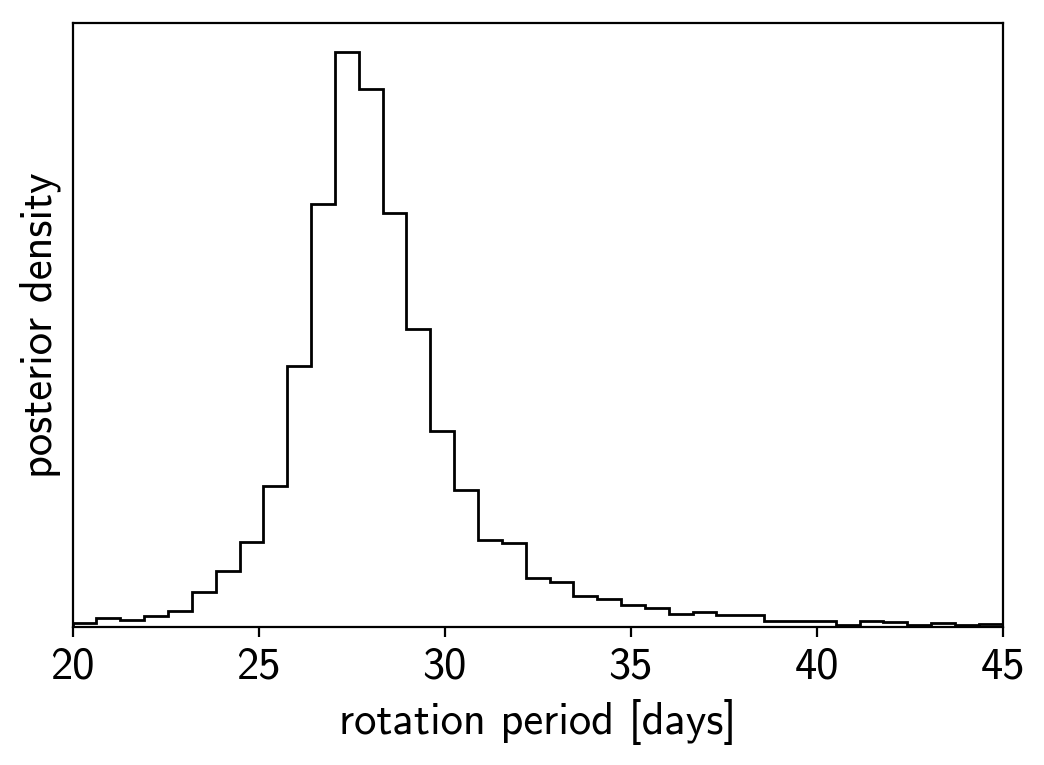

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");